# Model the density of the "accreted/unevolved" stellar halo selected in the Magnamal plane in APOGEE DR17

In [60]:
import os
import sys

os.environ['DUST_DIR'] = '/Users/dhortadarrington/Packages/mwdust/'

import numpy as np
import matplotlib.pyplot as plt
import utils
import densprofiles
from galpy.util import coords
import mwdust
import tqdm
import emcee
import dill as pickle
import multiprocessing
import scipy.optimize as op
from scipy import interpolate
from sklearn.mixture import GaussianMixture
from isodist import FEH2Z, Z2FEH
import corner
import safe_colours
import astropy.io.fits as fits

safe_colours = safe_colours.initialise()
col_dict = safe_colours.distinct_named()
cm_rainbow = safe_colours.colourmap('rainbow')
cm_heat = safe_colours.colourmap('heat')
cm_diverging = safe_colours.colourmap('diverging')

columnwidth = 240./72.27
textwidth = 504.0/72.27

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')

os.environ['RESULTS_VERS'] = 'dr17'
os.environ['SDSS_LOCAL_SAS_MIRROR'] = '/Users/dhortadarrington/Documents/Projects/halo-density/data/'
os.environ['ISODIST_DATA'] = '/Users/dhortadarrington/Packages/isodist/'


In [2]:
os.environ["PATH"]='/opt/homebrew/bin:/opt/homebrew/sbin:/Users/dhortadarrington/opt/\
    anaconda3/bin:/Users/dhortadarrington/opt/anaconda3/condabin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin'


In [3]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Master/data/dr17_dr3_McMillan_astroNN_rev1.fits'
tb = fits.open(path)
data = tb[1].data 

print(len(data))

733900


In [4]:
mask = np.load('../sav/mask_parent.npy', allow_pickle=True)
mask_une = np.load('../sav/mask_unevolved.npy', allow_pickle=True)
print(len(data[mask]), len(data[mask&mask_une]))

194257 4531


In [5]:
# lowfehbins = np.array([-3.,-1.6])
# lowafebins = np.array([0.,0.2,0.4])
ebins = [0.,0.7,1.]
ndistmods=301
minmax_distmods=[6.,18.] # from 0.1 to 40 kpc
nthreads = int(multiprocessing.cpu_count()//2)
isorec = utils.generate_lowfeh_isogrid()
dmap = mwdust.Combined19()
distmods = np.linspace(minmax_distmods[0], minmax_distmods[1], ndistmods)
ds = 10.**(distmods/5-2)

force = False
if os.path.exists('../sav/apogeeCombinedSF_DR17.dat') and not force:
    with open('../sav/apogeeCombinedSF_DR17.dat', 'rb') as f:
        apo = pickle.load(f)

if os.path.exists('../essf/effsel_grid_dr17-protoMW.dat') and not force:
    with open('../essf/effsel_grid_dr17-protoMW-2024.dat', 'rb') as f:
        outarea = pickle.load(f)


100%|███████████████████████████████████████████| 30/30 [00:01<00:00, 29.79it/s]


In [6]:
Indx = mask&mask_une

In [7]:
X, Y, Z = data['X']*8.275, data['Y']*8.275, data['Z']*8.275

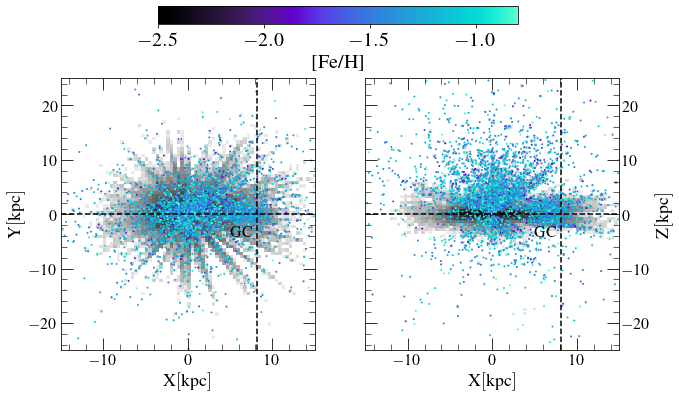

In [8]:
import cmasher as cm
from matplotlib.colors import LogNorm

#Plot the spatial distribution of the stars in x-y and x-z
fig, ax = plt.subplots(1,2,figsize=(10,5))
# fig.set_size_inches(textwidth,columnwidth)
plt.rc('font',family='serif',size=14)
# mask = (allstar_f['FE_H'] < -1.) & good_datamask & (allstar_f['C_FE'] < 0.15) &  (allstar_f['N_FE'] >= 0.5) & (allstar_f['FE_H'] > -3.)  & (allstar_f['LOGG'] < 3.) & (allstar_f['LOGG'] > 1.)
ax[0].hist2d(X[mask],Y[mask],bins=200,cmap='binary',norm=LogNorm())
# ax[0].scatter(XYZ[:,0][goodindx],XYZ[:,2][goodindx], c='k', s=2, lw=0., alpha=0.5, zorder=-1, rasterized=True)
color = ax[0].scatter(X[Indx],Y[Indx], c=data['FE_H'][Indx], s=1, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.8)
ax[0].axvline(8.178, c='Black', linestyle='dashed')
ax[0].axhline(0., c='Black', linestyle='dashed')
# ax[0].plot(8+5*x1,5*x2,c='k',ls='dashed',lw=0.5)
# ax[0].plot(8+10*x1,10*x2,c='k',ls='dashed',lw=0.5,label='5 kpc')
# ax[0].plot(8+15*x1,15*x2,c='k',ls='dashed',lw=0.5)
# ax[0].plot(8+20*x1,20*x2,c='k',ls='dashed',lw=0.5)
ax[0].set_ylim(-25,25)
ax[0].set_xlim(-15,15)
# ax[0].legend(loc='lower left',frameon=False)
ax[1].hist2d(X[mask],Z[mask],bins=200,cmap='binary',norm=LogNorm())
# ax[1].scatter(XYZ[:,0][goodindx],XYZ[:,1][goodindx], c='k', s=2, lw=0., alpha=0.5, zorder=-1, rasterized=True)
ax[1].scatter(X[Indx],Z[Indx], c=data['FE_H'][Indx], s=1, cmap=cm.cosmic, rasterized=True,vmin=-2.5,vmax=-0.8)
# ax[1].plot(8+5*x1,5*x2,c='k',ls='dashed',lw=0.5)
# ax[1].plot(8+10*x1,10*x2,c='k',ls='dashed',lw=0.5,label='5 kpc')
# ax[1].plot(8+15*x1,15*x2,c='k',ls='dashed',lw=0.5)
# ax[1].plot(8+20*x1,20*x2,c='k',ls='dashed',lw=0.5)
ax[1].axvline(8.178, c='Black', linestyle='dashed')
ax[1].axhline(0., c='Black', linestyle='dashed')
ax[1].set_ylim(-25,25)
ax[1].set_xlim(-15,15)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[0].set_xlabel(r'$\mathrm{X} \mathrm{[kpc]}$', fontsize=18)
ax[1].set_xlabel(r'$\mathrm{X} \mathrm{[kpc]}$', fontsize=18)
ax[0].set_ylabel(r'$\mathrm{Y} \mathrm{[kpc]}$', fontsize=18)
ax[1].set_ylabel(r'$\mathrm{Z} \mathrm{[kpc]}$', fontsize=18)
ax[0].text(5.,-4,r'GC', fontsize=16)
ax[1].text(5.,-4,r'GC', fontsize=16)
ax[0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12)
ax[0].tick_params(which='minor', length=6, direction='in',top=True,right=True)
ax[0].minorticks_on()
ax[1].tick_params(which='major',labelsize=16,direction='in',top=True, left=True,right=True,length=12)
ax[1].tick_params(which='minor', length=6, direction='in',top=True, left=True,right=True)
ax[1].minorticks_on()
# plt.savefig('../plots/spatial2.pdf', format='pdf', dpi=400, bbox_inches='tight')

cbar_ax = fig.add_axes([0.26, 1.03, 0.5,0.05])
cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
# cbar.set_label(label=r'L$_{z}$ [kpc kms$^{-1}$]',fontsize=20)
cbar.set_label(label=r'[Fe/H]',fontsize=20)
cbar.ax.tick_params(labelsize=20)

# plt.savefig('../plots/spatial_new.png', format='png', dpi=400, bbox_inches='tight',rasterized=True)


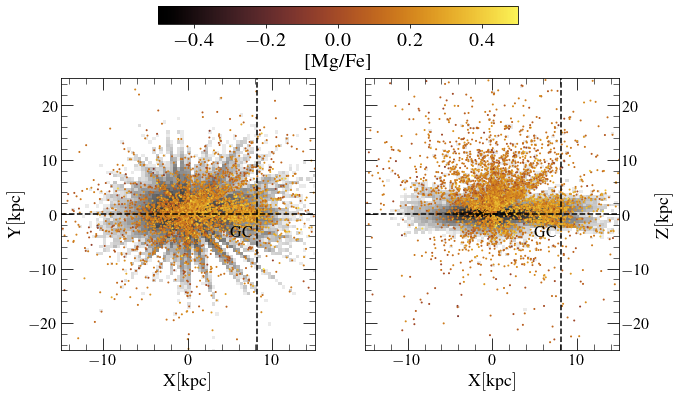

In [9]:
import cmasher as cm
from matplotlib.colors import LogNorm

#Plot the spatial distribution of the stars in x-y and x-z
fig, ax = plt.subplots(1,2,figsize=(10,5))
# fig.set_size_inches(textwidth,columnwidth)
plt.rc('font',family='serif',size=14)
# mask = (allstar_f['FE_H'] < -1.) & good_datamask & (allstar_f['C_FE'] < 0.15) &  (allstar_f['N_FE'] >= 0.5) & (allstar_f['FE_H'] > -3.)  & (allstar_f['LOGG'] < 3.) & (allstar_f['LOGG'] > 1.)
ax[0].hist2d(X[mask],Y[mask],bins=200,cmap='binary',norm=LogNorm())
# ax[0].scatter(XYZ[:,0][goodindx],XYZ[:,2][goodindx], c='k', s=2, lw=0., alpha=0.5, zorder=-1, rasterized=True)
color = ax[0].scatter(X[Indx],Y[Indx], c=data['MG_FE'][Indx], s=1, cmap=cm.amber, rasterized=True,vmin=-0.5,vmax=0.5)
ax[0].axvline(8.178, c='Black', linestyle='dashed')
ax[0].axhline(0., c='Black', linestyle='dashed')
# ax[0].plot(8+5*x1,5*x2,c='k',ls='dashed',lw=0.5)
# ax[0].plot(8+10*x1,10*x2,c='k',ls='dashed',lw=0.5,label='5 kpc')
# ax[0].plot(8+15*x1,15*x2,c='k',ls='dashed',lw=0.5)
# ax[0].plot(8+20*x1,20*x2,c='k',ls='dashed',lw=0.5)
ax[0].set_ylim(-25,25)
ax[0].set_xlim(-15,15)
# ax[0].legend(loc='lower left',frameon=False)
ax[1].hist2d(X[mask],Z[mask],bins=200,cmap='binary',norm=LogNorm())
# ax[1].scatter(XYZ[:,0][goodindx],XYZ[:,1][goodindx], c='k', s=2, lw=0., alpha=0.5, zorder=-1, rasterized=True)
ax[1].scatter(X[Indx],Z[Indx], c=data['MG_FE'][Indx], s=1, cmap=cm.amber, rasterized=True,vmin=-0.5,vmax=0.5)
# ax[1].plot(8+5*x1,5*x2,c='k',ls='dashed',lw=0.5)
# ax[1].plot(8+10*x1,10*x2,c='k',ls='dashed',lw=0.5,label='5 kpc')
# ax[1].plot(8+15*x1,15*x2,c='k',ls='dashed',lw=0.5)
# ax[1].plot(8+20*x1,20*x2,c='k',ls='dashed',lw=0.5)
ax[1].axvline(8.178, c='Black', linestyle='dashed')
ax[1].axhline(0., c='Black', linestyle='dashed')
ax[1].set_ylim(-25,25)
ax[1].set_xlim(-15,15)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[0].set_xlabel(r'$\mathrm{X} \mathrm{[kpc]}$', fontsize=18)
ax[1].set_xlabel(r'$\mathrm{X} \mathrm{[kpc]}$', fontsize=18)
ax[0].set_ylabel(r'$\mathrm{Y} \mathrm{[kpc]}$', fontsize=18)
ax[1].set_ylabel(r'$\mathrm{Z} \mathrm{[kpc]}$', fontsize=18)
ax[0].text(5.,-4,r'GC', fontsize=16)
ax[1].text(5.,-4,r'GC', fontsize=16)
ax[0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12)
ax[0].tick_params(which='minor', length=6, direction='in',top=True,right=True)
ax[0].minorticks_on()
ax[1].tick_params(which='major',labelsize=16,direction='in',top=True, left=True,right=True,length=12)
ax[1].tick_params(which='minor', length=6, direction='in',top=True, left=True,right=True)
ax[1].minorticks_on()
# plt.savefig('../plots/spatial2.pdf', format='pdf', dpi=400, bbox_inches='tight')

cbar_ax = fig.add_axes([0.26, 1.03, 0.5,0.05])
cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
# cbar.set_label(label=r'L$_{z}$ [kpc kms$^{-1}$]',fontsize=20)
cbar.set_label(label=r'[Mg/Fe]',fontsize=20)
cbar.ax.tick_params(labelsize=20)

# plt.savefig('../plots/spatial_new.png', format='png', dpi=400, bbox_inches='tight',rasterized=True)


In [10]:
rads = np.sqrt(X**2 + Z**2)

In [11]:
rapo = np.load('../sav/rapo_gala.npy', allow_pickle=True)
print(len(rapo))

4531


# Slice the magnamal ``unevolved'' stars in the Tinsley diagram and fit a profile that is an einasto with a parameter that has contamination from a halo like GES, taking the best fit params from Ted's paper

In [12]:
#remove fields where effsel == 0 everywhere?
goodfields = ~np.all(outarea < 1e-9, axis=1)
# remove fields in the bulge direction
aposel_glons = np.array([apo.glonGlat(x)[0][0] for x in apo._locations])
aposel_glats = np.array([apo.glonGlat(x)[1][0] for x in apo._locations])
# bulgeindx = ((aposel_glons > 355) | (aposel_glons < 5)) & (np.fabs(aposel_glats) < 5)
# goodindx = goodfields & ~bulgeindx & (apo._locations != 5093) #remove bad fields
goodindx_eff = goodfields & (apo._locations != 5093) #remove bad fields
goodlocs = apo._locations[goodindx_eff]
# remove data not in the final field list
good_datamask = [data['LOCATION_ID'][i] in goodlocs for i in tqdm.tqdm_notebook(range(len(data)))]
# good_datamask *= data['weighted_dist']/data['weighted_dist_error'] > 5.


  0%|          | 0/733900 [00:00<?, ?it/s]

In [13]:
#these functions are necessary to do the fits to the APOGEE giants. They could be in with the utils, but for simplicity, I just put them here!
from scipy import integrate

#first need to get the minimum J-K in each field
jkmins = np.array([apo.JKmin(apo._locations[i]) for i in range(len(apo._locations))])
jkmaxs = np.array([apo.JKmax(apo._locations[i]) for i in range(len(apo._locations))])

def calc_bic_loglike(mask, params, fehrange=[-2.5,-0.5], effsel=outarea, model = densprofiles.spherical):
    loglike = utils.loglike(params,model, effsel[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][mask],Rphiz[:,1][mask], Rphiz[:,2][mask])
    print((sum(mask)))
    bic = sum(params)*np.log(sum(mask))-2*loglike
    return bic, loglike
    
def fit_bin_mask(mask, fehrange=[-2.5,-0.5], effsel=outarea, model=densprofiles.spherical, just_MLE=True, just_MCMC=False, mass=False, init= [2.], ncut=100, analytic=False, inttype='spherical'):
    '''
    Fits the stars defined by a mask to the APOGEE low metallicity sample
    IN:
    mask - must be same length as gaia2_matches[omask], and must have Fe/H limits that go into fehrange.
    fehrange - the range in Fe/H spanned by the sample defined by mask
    effsel - the effective selection function corresponding to the sample in mask
    model - the density model to be fit
    just_MLE - do the Maximum Likelihood and return opt
    just_MCMC - do the MCMC
    mass - also compute the total mass
    init - initial input parameters for the density model
    ncut - number of samples to cut from each MCMC chain
    analytic - compute the mass integral analytically (only works for spherical density models)
    inttype - the coordinate scheme for the integration grid for mass computation
    OUTPUT:
    opt - opt from op.minimize
    samples - MCMC samples
    masses - MC samples of mass
    facs - the normalisation factor corresponding to each mass sample
    '''
    #needs goodindx_eff defined above. 'mask' must be same length as gaia2_matches[omask].
    print(sum(mask))
    if not just_MCMC:
        # do MLE. 
        mloglike = lambda x: utils.mloglike(x,model, effsel[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][mask],Rphiz[:,1][mask], Rphiz[:,2][mask])
        print(mloglike)
        opt = op.fmin(lambda x: utils.mloglike(x,model, effsel[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][mask],Rphiz[:,1][mask], Rphiz[:,2][mask]), init, full_output=True)
        print(opt[0])
        if just_MLE:
            return opt
    # do MCMC initialised from best result from MLE or from init params given
    ndim, nwalkers = len(init), 100
    if just_MCMC:
        pos = [init + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
    else:
        pos = [opt[0] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
    nit = 1000
    threads = 4
    #only effsel for good fields
    effsel_in = effsel[goodindx_eff]*ds**3*np.log(10)/5.*(distmods[1]-distmods[0])
    #re-build Rphiz grid
    Rgrid_in, phigrid_in, zgrid_in = Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff]
    #set up sampler and do the sampling.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, utils.loglike, 
                                        args=(model, effsel_in, Rgrid_in, phigrid_in, zgrid_in, Rphiz[:,0][mask], Rphiz[:,1][mask], Rphiz[:,2][mask]), 
                                        threads=threads,moves=[(emcee.moves.DEMove(), 0.8), (emcee.moves.DEMove(), 0.2)])
    for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
        continue
    #cut ncut samples from each chain
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    if not mass:
        if just_MCMC:
            return samples
        else:
            return opt, samples, sampler
        
    isofactors = np.zeros(len(effsel[goodindx_eff]))
    for i in tqdm.tqdm_notebook(range(len(isofactors))):   
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['Jmag']-isorec['Ksmag'] > jkmins[goodindx_eff][i]) & (isorec['logg'] > 0.5) & (isorec['logg'] < 3.5) & (isorec['logAge'] > 10) & (10**(isorec['logTe']) > 4000.) & (10**(isorec['logTe']) < 5500.)
        avmass = utils.average_mass(isorec[isomask], lowfehgrid=True)
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['logAge'] > 10)  #& (isorec['J']-isorec['K'] > 0.3) & (isorec['logg'] < 3) & (isorec['logg'] > 1)
        massratio = utils.mass_ratio(isorec[isomask], lowfehgrid=True, minjk=jkmins[goodindx_eff][i], maxjk=jkmaxs[goodindx_eff][i])
        isofactors[i] = avmass/massratio #fraction of stellar mass in giants
        #set up grid for integration
        rthetaphigrid = np.mgrid[0.1:40.:150j,0:np.pi:150j,0:2*np.pi:150j]
        dr = (40.-0.1)/149
        dtheta = (np.pi-0.)/149
        dphi = (2*np.pi-0.)/149
        shape = np.shape(rthetaphigrid.T)
        rthetaphigrid = rthetaphigrid.T.reshape(np.product(shape[:3]),shape[3])
        deltafactor = rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1])*dr*dtheta*dphi
        x = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.cos(rthetaphigrid[:,2])
        y = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.sin(rthetaphigrid[:,2])
        z = rthetaphigrid[:,0]*np.cos(rthetaphigrid[:,1])
        xyzgrid = np.dstack([x,y,z])[0]
        rphizgrid = coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
        rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
    if model is densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk:
#     densprofiles.broken_pw or model is densprofiles.triple_pw or model is densprofiles.spl_pw or model is densprofiles.einasto_expdisc\
#     or model is densprofiles.einasto_rot or model is densprofiles.einasto_expdisc_cutoff or model is densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk\
#     or model is densprofiles.cored_powerlaw_plusexpdisc or model is densprofiles.einasto_geshalo:
        masses = np.zeros((400,3))
    else: 
        masses = np.zeros(400)
        
    facs = np.zeros(400)
#     sumrates = np.zeros(400)
    for ii,params in tqdm.tqdm_notebook(enumerate(samples[np.random.choice(len(samples), 400, replace=False)]), total=400):
        rate = model(Rgrid[goodindx_eff],phigrid[goodindx_eff],zgrid[goodindx_eff],params=params)*effsel[goodindx_eff]*ds**3*np.log(10)/5.*(distmods[1]-distmods[0])
        sumrate = np.sum(rate.T/isofactors) #conversion factor between RGB number counts and total stellar mass
        norm = sum(mask)/sumrate
        fac = norm*(180./np.pi)**2  #conversion factor between RGB number counts and total stellar mass accounted for density normalisation
        if analytic:
            #only for spherical power law!
            rsun = np.sqrt(8.275**2+0.02**2)
            min_r = 0.1
            max_r = 40.
            alpha = params[0]
            integral = 4*np.pi*((rsun**alpha*max_r**(3-alpha))/(3-alpha)-(rsun**alpha*min_r**(3-alpha))/(3-alpha))
            masses[ii] = integral*fac
        elif model is densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk:
#         densprofiles.broken_pw or model is densprofiles.triple_pw or model is densprofiles.spl_pw or model is densprofiles.einasto_expdisc\
#         or model is densprofiles.einasto_rot or model is densprofiles.einasto_expdisc_cutoff or model is densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk\
#         or model is densprofiles.cored_powerlaw_plusexpdisc or model is densprofiles.einasto_geshalo:            
            denstxyz = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params, split=True)
            halodens = denstxyz[0]*fac
            diskdens = denstxyz[1]*fac
            fulldens = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)*fac
            masses[ii] = np.sum(fulldens*deltafactor), np.sum(halodens*deltafactor), np.sum(diskdens*deltafactor)
        else:
            fulldens = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)*fac
            masses[ii] = np.sum(fulldens*deltafactor)
        facs[ii] = fac
#         sumrates[ii] = sumrate
    if just_MCMC:
        return samples, masses, facs
    return opt, samples,sampler, masses, facs


In [14]:
Rgrid, phigrid, zgrid = utils.Rphizgrid(apo, distmods)

import cmasher as cm
#Calculate the XYZ and Rphiz coordinates of the two samples and the rest of APOGEE DR14.
def allstar_to_coords(dat):
    l, b, d = dat['GLON'], dat['GLAT'], dat['weighted_dist']/1e3
    XYZ = coords.lbd_to_XYZ(l,b,d, degree=True)
    Rphiz = coords.XYZ_to_galcencyl(XYZ[:,0], XYZ[:,1], XYZ[:,2], Xsun=8.178, Zsun=0.02)
    return XYZ, Rphiz
XYZ, Rphiz = allstar_to_coords(data)

In [15]:
def pdistmod_model(densfunc, params, effsel, returnrate=False):
    rate = (densfunc(Rgrid[goodindx_eff],phigrid[goodindx_eff],zgrid[goodindx_eff],params=params))*effsel[goodindx_eff]*ds**3
    
    pdt = np.sum(rate,axis=0)
    pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])
    if returnrate:
        return pd, pdt, rate
    return pd, pdt

# First fit all the unevolved stars together

we will test a SPL (spherical, axisymmetric, triaxial), an exponential disc, an Einasto (spherical, with disc, with GES model, with cutoff), and a cored power law (spherical, and with a disc)

In [16]:
Indx = mask&mask_une
print(len(data[Indx]))

4531


In [17]:
# # SPL, axi, triaxial

# opt_spherical = op.fmin(lambda x: utils.mloglike(x,densprofiles.spherical, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2.], full_output=True)
# spherical_pd, spherical_pdt, spherical_rate = pdistmod_model(densprofiles.spherical,opt_spherical[0], outarea, returnrate=True)

# opt_axi = op.fmin(lambda x: utils.mloglike(x,densprofiles.axisymmetric, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 5.], full_output=True)
# axi_pd, axi_pdt, axi_rate = pdistmod_model(densprofiles.axisymmetric, opt_axi[0], outarea, returnrate=True)

# opt_tri = op.fmin(lambda x: utils.mloglike(x,densprofiles.triaxial, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 5., 1.], full_output=True)
# tri_pd, tri_pdt, tri_rate = pdistmod_model(densprofiles.triaxial,opt_tri[0], outarea, returnrate=True)


In [18]:
# Einasto, Einasto_disc, Einasto_ges, Einasto_cutoff

opt_ein = op.fmin(lambda x: utils.mloglike(x,densprofiles.einasto, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 5.], full_output=True)
ein_pd, ein_pdt, ein_rate = pdistmod_model(densprofiles.einasto,opt_ein[0], outarea, returnrate=True)

opt_ein_disc = op.fmin(lambda x: utils.mloglike(x,densprofiles.einasto_expdisc, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 5., 0.], full_output=True)
ein_disc_pd, ein_disc_pdt, ein_disc_rate = pdistmod_model(densprofiles.einasto_expdisc,opt_ein_disc[0], outarea, returnrate=True)

# exp disc
opt_expdisc = op.fmin(lambda x: utils.mloglike(x,densprofiles.justexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [1/1.8,1/0.8], full_output=True)
expdisc_pd, expdisc_pdt, expdisc_rate = pdistmod_model(densprofiles.justexpdisk,opt_expdisc[0], outarea, returnrate=True)

# cored power law
opt_cpl = op.fmin(lambda x: utils.mloglike(x,densprofiles.cored_powerlaw, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 5.], full_output=True)
cpl_pd, cpl_pdt, cpl_rate = pdistmod_model(densprofiles.cored_powerlaw,opt_cpl[0], outarea, returnrate=True)

opt_cpl_disc = op.fmin(lambda x: utils.mloglike(x,densprofiles.cored_powerlaw_plusexpdisc, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 5., 0.], full_output=True)
cpl_disc_pd, cpl_pdt_disc, cpl_disc_rate = pdistmod_model(densprofiles.cored_powerlaw_plusexpdisc,opt_cpl_disc[0], outarea, returnrate=True)


Optimization terminated successfully.
         Current function value: 41638.412751
         Iterations: 95
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 41638.062901
         Iterations: 133
         Function evaluations: 253
Optimization terminated successfully.
         Current function value: 42464.036804
         Iterations: 43
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 41592.998941
         Iterations: 72
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 41592.956401
         Iterations: 103
         Function evaluations: 193


In [19]:
# Halo model
opt_halo = op.fmin(lambda x: utils.mloglike(x,densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2.,1.,0.5,0.5,0.,0.,0.,0.01], full_output=True)
halo_pd, halo_pdt, halo_rate = pdistmod_model(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,opt_halo[0], outarea, returnrate=True)

# plummer, hernquist, sersic

opt_plummer = op.fmin(lambda x: utils.mloglike(x,densprofiles.plummer, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2.], full_output=True)
plummer_pd, plummer_pdt, plummer_rate = pdistmod_model(densprofiles.plummer,opt_plummer[0], outarea, returnrate=True)

opt_hern = op.fmin(lambda x: utils.mloglike(x,densprofiles.hernquist, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2.], full_output=True)
hern_pd, hern_pdt, hern_rate = pdistmod_model(densprofiles.hernquist, opt_hern[0], outarea, returnrate=True)

opt_sersic = op.fmin(lambda x: utils.mloglike(x,densprofiles.sersic, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [8., 0.5, 5.], full_output=True)
sersic_pd, sersic_pdt, sersic_rate = pdistmod_model(densprofiles.sersic,opt_sersic[0], outarea, returnrate=True)


Optimization terminated successfully.
         Current function value: 41872.674201
         Iterations: 454
         Function evaluations: 769
Optimization terminated successfully.
         Current function value: 42347.154413
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 41677.689685
         Iterations: 45
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 41769.902498
         Iterations: 140
         Function evaluations: 258


In [20]:
# Halo model
opt_einhalo = op.fmin(lambda x: utils.mloglike(x,densprofiles.einasto_geshalo, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [4., 5., 0.], full_output=True)
einhalo_pd, einhalo_pdt, einhalo_rate = pdistmod_model(densprofiles.einasto_geshalo,opt_einhalo[0], outarea, returnrate=True)


In [21]:
opt_plummer_axi = op.fmin(lambda x: utils.mloglike(x,densprofiles.plummer_axi, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 0., 0.], full_output=True)
plummer_axi_pd, plummer_axi_pdt, plummer_axi_rate = pdistmod_model(densprofiles.plummer_axi,opt_plummer_axi[0], outarea, returnrate=True)


Optimization terminated successfully.
         Current function value: 42372.475464
         Iterations: 169
         Function evaluations: 318


Text(0, 0.5, '$f_{(x)}$')

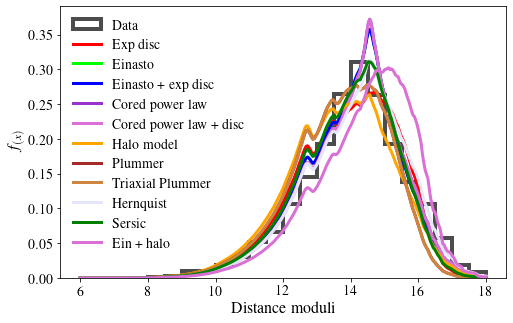

In [22]:
plt.figure(figsize=(8,5), facecolor='white')

data_distmod= 5*np.log10(data['weighted_dist'][Indx]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,expdisc_pd,lw=3., color='r', label='Exp disc')
plt.plot(distmods,ein_pd,lw=3., color='lime', label='Einasto')
plt.plot(distmods, ein_disc_pd,lw=3., color='b', label='Einasto + exp disc')
plt.plot(distmods,cpl_pd,lw=3., color='darkorchid', label='Cored power law')
plt.plot(distmods,cpl_disc_pd,lw=3., color='orchid', label='Cored power law + disc')
plt.plot(distmods,halo_pd,lw=3., color='orange', label='Halo model')
plt.plot(distmods,plummer_pd,lw=3., color='brown', label='Plummer')
plt.plot(distmods,plummer_pd,lw=3., color='peru', label='Triaxial Plummer')
plt.plot(distmods,hern_pd,lw=3., color='lavender', label='Hernquist')
plt.plot(distmods,sersic_pd,lw=3., color='g', label='Sersic')
plt.plot(distmods,einhalo_pd,lw=3., color='orchid', label='Ein + halo')

plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)


# plt.savefig('../plots/dens-fit-all.png', format='png', dpi=200, bbox_inches='tight')


# test that the halo model works well for stars with high eccentricities

In [61]:
# Halo model
Indx = mask&mask_une&(data['ecc']>0.7)&(data['FE_H']<-1)
opt_halo = op.fmin(lambda x: utils.mloglike(x,densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2.,1.,0.5,0.5,0.,0.,0.,0.01], full_output=True)
halo_pd, halo_pdt, halo_rate = pdistmod_model(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,opt_halo[0], outarea, returnrate=True)


In [62]:
opt_halo

(array([1.57287966e+00, 6.33518405e-02, 5.73907764e-01, 7.98672389e-01,
        5.43331592e-10, 4.64845040e-04, 5.23788127e-07, 8.70503921e-03]),
 23420.53077541906,
 1042,
 1600,
 1)

Text(0, 0.5, '$f_{(x)}$')

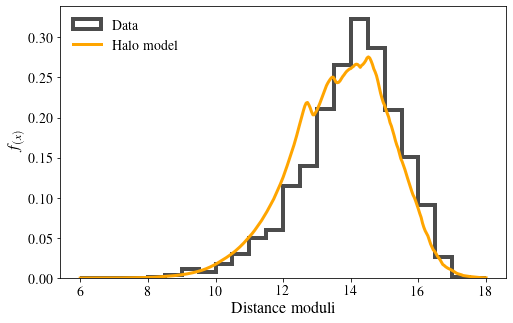

In [63]:
plt.figure(figsize=(8,5), facecolor='white')

data_distmod= 5*np.log10(data['weighted_dist'][Indx]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],25), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
plt.plot(distmods,halo_pd,lw=3., color='orange', label='Halo model')

plt.legend(frameon=False,loc='upper left')
plt.xlabel('Distance moduli',fontsize=16)
plt.ylabel(r'$f_{(x)}$',fontsize=16)



(array([  7.,  13.,  63.,  82., 151., 264., 456., 596., 561., 355.]),
 array([-2.14580011, -2.03130007, -1.91680014, -1.8023001 , -1.68780005,
        -1.57330012, -1.45880008, -1.34430003, -1.22979999, -1.11530006,
        -1.00080001]),
 <BarContainer object of 10 artists>)

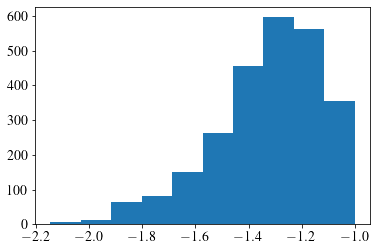

In [64]:
plt.hist(data['FE_H'][Indx])

In [65]:
Indx = mask&mask_une&(data['ecc']>0.7)&(data['FE_H']<-1)
opt_highe, samples_highe, sampler_highe, masses_highe, facs_highe = fit_bin_mask(Indx, fehrange=[-2.,-1.], effsel=outarea, model=densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, just_MLE=False, just_MCMC=False, mass=True, init= [2.,1.,0.5,0.5,0.,0.,0.,0.01], ncut=100, analytic=False)


2548
<function fit_bin_mask.<locals>.<lambda> at 0x68474d940>
[1.57287966e+00 6.33518405e-02 5.73907764e-01 7.98672389e-01
 5.43331592e-10 4.64845040e-04 5.23788127e-07 8.70503921e-03]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1441 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [69]:
# save the values
np.save('../sav/opt_trispl_halo-eccgrt0point7-minus1', opt_highe[0])
np.save('../sav/lhood_trispl_halo-eccgrt0point7-minus1', opt_highe[1])
np.save('../sav/samples_trispl_halo-eccgrt0point7-minus1', samples_highe)
np.save('../sav/sampler_trispl_halo-eccgrt0point7-minus1', sampler_highe)
np.save('../sav/masses_trispl_halo-eccgrt0point7-minus1', masses_highe)
np.save('../sav/facs_trispl_halo-eccgrt0point7-minus1', facs_highe)

In [70]:
np.nanpercentile(masses_highe, [16,50,84])

array([1.96371462e+08, 4.34082831e+09, 4.64630930e+09])

# first model all cells (1-3) together

In [62]:
c1 = np.load('../sav/mask_c1.npy',allow_pickle=True)
c2 = np.load('../sav/mask_c2.npy',allow_pickle=True)
c3 = np.load('../sav/mask_c3.npy',allow_pickle=True)
c4 = np.load('../sav/mask_c4.npy',allow_pickle=True)
c5 = np.load('../sav/mask_c5.npy',allow_pickle=True)
c6 = np.load('../sav/mask_c6.npy',allow_pickle=True)
c7 = np.load('../sav/mask_c7.npy',allow_pickle=True)
c8 = np.load('../sav/mask_c8.npy',allow_pickle=True)
c9 = np.load('../sav/mask_c9.npy',allow_pickle=True)

mask_tot = np.any([c1, c2, c3], axis=0)

In [63]:
Indx = mask_tot
print(len(data[Indx]))

1363


In [132]:
# Einasto, Einasto_disc, Einasto_ges, Einasto_cutoff

opt_ein_comb = op.fmin(lambda x: utils.mloglike(x,densprofiles.einasto, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 5.], full_output=True)
ein_comb_pd, ein_comb_pdt, ein_comb_rate = pdistmod_model(densprofiles.einasto,opt_ein_comb[0], outarea, returnrate=True)

opt_ein_disc_comb = op.fmin(lambda x: utils.mloglike(x,densprofiles.einasto_expdisc, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 5., 0.], full_output=True)
ein_disc_comb_pd, ein_disc_comb_pdt, ein_disc_comb_rate = pdistmod_model(densprofiles.einasto_expdisc,opt_ein_disc_comb[0], outarea, returnrate=True)

# exp disc
opt_expdisc_comb = op.fmin(lambda x: utils.mloglike(x,densprofiles.justexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [1/1.8,1/0.8], full_output=True)
expdisc_comb_pd, expdisc_comb_pdt, expdisc_comb_rate = pdistmod_model(densprofiles.justexpdisk,opt_expdisc_comb[0], outarea, returnrate=True)

# cored power law
opt_cpl_comb = op.fmin(lambda x: utils.mloglike(x,densprofiles.cored_powerlaw, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 5.], full_output=True)
cpl_comb_pd, cpl_comb_pdt, cpl_comb_rate = pdistmod_model(densprofiles.cored_powerlaw,opt_cpl_comb[0], outarea, returnrate=True)

opt_cpl_axi_comb = op.fmin(lambda x: utils.mloglike(x,densprofiles.cored_powerlaw_axi, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 5., 0., 0.], full_output=True)
cpl_axi_comb_pd, cpl_pdt_axi_comb, cpl_axi_comb_rate = pdistmod_model(densprofiles.cored_powerlaw_axi,opt_cpl_axi_comb[0], outarea, returnrate=True)


Optimization terminated successfully.
         Current function value: 10940.608808
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: 10914.773292
         Iterations: 141
         Function evaluations: 256
Optimization terminated successfully.
         Current function value: 11051.620057
         Iterations: 36
         Function evaluations: 71
Optimization terminated successfully.
         Current function value: 10951.252039
         Iterations: 56
         Function evaluations: 106


In [131]:
opt_cpl_axi_comb

(array([2., 5., 0.]), inf, 120, 600, 1)

In [66]:
# Halo model
opt_halo_comb = op.fmin(lambda x: utils.mloglike(x,densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2.,1.,0.5,0.5,0.,0.,0.,0.01], full_output=True)
halo_comb_pd, halo_comb_pdt, halo_comb_rate = pdistmod_model(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk,opt_halo_comb[0], outarea, returnrate=True)

# plummer, hernquist, sersic

opt_plummer_comb = op.fmin(lambda x: utils.mloglike(x,densprofiles.plummer, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2.], full_output=True)
plummer_comb_pd, plummer_comb_pdt, plummer_comb_rate = pdistmod_model(densprofiles.plummer,opt_plummer_comb[0], outarea, returnrate=True)

opt_hern_comb = op.fmin(lambda x: utils.mloglike(x,densprofiles.hernquist, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2.], full_output=True)
hern_comb_pd, hern_comb_pdt, hern_comb_rate = pdistmod_model(densprofiles.hernquist, opt_hern_comb[0], outarea, returnrate=True)

opt_sersic_comb = op.fmin(lambda x: utils.mloglike(x,densprofiles.sersic, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [8., 0.5, 5.], full_output=True)
sersic_comb_pd, sersic_comb_pdt, sersic_comb_rate = pdistmod_model(densprofiles.sersic,opt_sersic_comb[0], outarea, returnrate=True)


Optimization terminated successfully.
         Current function value: 10836.673309
         Iterations: 751
         Function evaluations: 1178
Optimization terminated successfully.
         Current function value: 10994.792183
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 11443.163347
         Iterations: 45
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 10941.355908
         Iterations: 145
         Function evaluations: 266


In [137]:
opt_sersic_comb

(array([2.23815883, 1.18885196, 0.10000154]), 10941.355907964642, 145, 266, 0)

In [134]:
print(7.10e-11 * 180/np.pi)
print(3.24e-03 * 180/np.pi)
print(4.81e-04 * 180/np.pi)


4.068000345428845e-09
0.18563832562238672
0.027559269945792594


In [114]:
# Halo model
opt_plummer_axi_comb = op.fmin(lambda x: utils.mloglike(x,densprofiles.plummer_axi, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 0., 0.], full_output=True)
plummer_axi_comb_pd, plummer_axi_comb_pdt, plummer_axi_comb_rate = pdistmod_model(densprofiles.plummer_axi,opt_plummer_axi_comb[0], outarea, returnrate=True)

opt_hern_axi_comb = op.fmin(lambda x: utils.mloglike(x,densprofiles.hernquist_axi, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 0., 0.], full_output=True)
hern_axi_comb_pd, hern_axi_comb_pdt, hern_axi_comb_rate = pdistmod_model(densprofiles.hernquist_axi,opt_hern_axi_comb[0], outarea, returnrate=True)

opt_sersic_axi_comb = op.fmin(lambda x: utils.mloglike(x,densprofiles.sersic_axi, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 0., 0., 0., 0.], full_output=True)
sersic_axi_comb_pd, sersic_axi_comb_pdt, sersic_axi_comb_rate = pdistmod_model(densprofiles.sersic_axi,opt_sersic_axi_comb[0], outarea, returnrate=True)

opt_ein_axi_comb = op.fmin(lambda x: utils.mloglike(x,densprofiles.einasto_axisymmetric, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][Indx],Rphiz[:,1][Indx], Rphiz[:,2][Indx]), [2., 5., 0.], full_output=True)
ein_axi_comb_pd, ein_axi_comb_pdt, ein_axi_comb_rate = pdistmod_model(densprofiles.einasto_axisymmetric,opt_ein_axi_comb[0], outarea, returnrate=True)



Optimization terminated successfully.
         Current function value: 10902.263243
         Iterations: 178
         Function evaluations: 323
Optimization terminated successfully.
         Current function value: 11410.027941
         Iterations: 165
         Function evaluations: 312


In [141]:
opt_ein_axi_comb

(array([2., 5., 0.]), inf, 120, 600, 1)

# Now split the sample into the chemical cells and run the density modelling again

In [73]:
c1 = np.load('../sav/mask_c1.npy',allow_pickle=True)
c2 = np.load('../sav/mask_c2.npy',allow_pickle=True)
c3 = np.load('../sav/mask_c3.npy',allow_pickle=True)
c4 = np.load('../sav/mask_c4.npy',allow_pickle=True)
c5 = np.load('../sav/mask_c5.npy',allow_pickle=True)
c6 = np.load('../sav/mask_c6.npy',allow_pickle=True)
c7 = np.load('../sav/mask_c7.npy',allow_pickle=True)
c8 = np.load('../sav/mask_c8.npy',allow_pickle=True)
c9 = np.load('../sav/mask_c9.npy',allow_pickle=True)

mask_tot = np.any([c1, c2, c3], axis=0)

In [74]:
masks_c = [c1, c2, c3, c4, c5, c6, c7, c8, c9]

In [75]:
def calc_bic_aic(k, N, lhood):
    
    bic = k * np.log(N) + 2*np.log(lhood) # plus here as we use the minus loglikelihood
    aic = 2*k + 2*np.log(lhood)
    
    return bic, aic

def fit_cells(densprofile, masks, init_params = [2.,5.]):
    
    opt_cells = []
    lhood_cells = []
    bic_cells = []
    aic_cells = []
    pd_cells = []
    pdt_cells = []
    rate_cells = [] 

    for indx, i in tqdm.tqdm_notebook(enumerate(masks)):

        opt = op.fmin(lambda x: utils.mloglike(x,densprofile, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][i],Rphiz[:,1][i], Rphiz[:,2][i]), init_params, full_output=True)
        pd, pdt, rate = pdistmod_model(densprofile,opt[0], outarea, returnrate=True)
        
        bic, aic = calc_bic_aic(len(opt[0]), len(Rphiz[:,2][i]), opt[1])

        opt_cells.append(opt[0])
        lhood_cells.append(opt[1])
        bic_cells.append(bic)
        aic_cells.append(aic)
        pd_cells.append(pd) 
        pdt_cells.append(pdt) 
        rate_cells.append(rate)                      
                                       
    return np.array(opt_cells), np.array(lhood_cells), np.array(pd_cells), np.array(pdt_cells), np.array(rate_cells), np.array(bic_cells), np.array(aic_cells)


We will start by fitting just the simple form of the profile for each family. Once figured out which is the best profile, we will test adding parameters

In [76]:
# exp disc
opt_expdisc_cells, lhood_expdisc_cells, pd_expdisc_cells, pdt_expdisc_cells, rate_expdisc_cells, bic_expdisc_cells, aic_expdisc_cells\
= fit_cells(densprofiles.justexpdisk, masks_c, init_params = [1/2.2,1/0.8])


0it [00:00, ?it/s]

Optimization terminated successfully.
         Current function value: 2933.897672
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 7666.420993
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 415.401858
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: 3693.749574
         Iterations: 42
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 18811.720459
         Iterations: 43
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 4602.417640
         Iterations: 40
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: 278.315493
         Iterations: 77
         Function evaluations: 151
Optimization 

In [77]:
# Einasto
opt_ein_cells, lhood_ein_cells, pd_ein_cells, pdt_ein_cells, rate_ein_cells, bic_ein_cells, aic_ein_cells\
= fit_cells(densprofiles.einasto, masks_c, init_params = [2.,5.])


0it [00:00, ?it/s]

Optimization terminated successfully.
         Current function value: 2921.591727
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 7574.147512
         Iterations: 33
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 422.320326
         Iterations: 40
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 3649.806074
         Iterations: 80
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 18667.021591
         Iterations: 86
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: 4581.303311
         Iterations: 52
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: 1027.546169
         Iterations: 79
         Function evaluations: 151
Optimizati

In [78]:
opt_ein_cells

array([[ 1.63876939,  5.99264529],
       [ 2.53240123,  3.83833023],
       [ 3.50900566,  2.82912428],
       [ 4.74064001, 39.99999965],
       [ 3.52663331, 39.99999989],
       [ 3.27580199, 30.39051176],
       [ 0.07687231, 16.61244218],
       [ 0.04226432, 37.76600594],
       [ 1.59954127, 39.99999909]])

In [79]:
# Einasto triaxial
opt_ein_axi_cells, lhood_ein_axi_cells, pd_ein_axi_cells, pdt_ein_axi_cells, rate_ein_axi_cells, bic_ein_axi_cells, aic_ein_axi_cells\
= fit_cells(densprofiles.einasto_triaxial, masks_c, init_params = [2.,5., 0.,0.])


0it [00:00, ?it/s]

In [80]:
opt_ein_axi_cells

array([[2., 5., 0., 0.],
       [2., 5., 0., 0.],
       [2., 5., 0., 0.],
       [2., 5., 0., 0.],
       [2., 5., 0., 0.],
       [2., 5., 0., 0.],
       [2., 5., 0., 0.],
       [2., 5., 0., 0.],
       [2., 5., 0., 0.]])

In [81]:
# einasto + disc
# opt_ein_disc_cells, lhood_ein_disc_cells, pd_ein_disc_cells, pdt_ein_disc_cells, rate_ein_disc_cells, bic_ein_disc_cells, aic_ein_disc_cells\
# = fit_cells(densprofiles.einasto_expdisc, masks_c, init_params = [2.,5.,0.])


In [82]:
# einasto + halo
opt_ein_halo_cells, lhood_ein_halo_cells, pd_ein_halo_cells, pdt_ein_halo_cells, rate_ein_halo_cells, bic_ein_halo_cells, aic_ein_halo_cells\
= fit_cells(densprofiles.einasto_geshalo, masks_c, init_params = [4., 5., 0.])


0it [00:00, ?it/s]

In [83]:
opt_ein_halo_cells

array([[4., 5., 0.],
       [4., 5., 0.],
       [4., 5., 0.],
       [4., 5., 0.],
       [4., 5., 0.],
       [4., 5., 0.],
       [4., 5., 0.],
       [4., 5., 0.],
       [4., 5., 0.]])

In [84]:
# # cpl + disc
# opt_cpl_disc_cells, lhood_cpl_disc_cells, pd_cpl_disc_cells, pdt_cpl_disc_cells, rate_ein_disc_tri_cells,\
# bic_cpl_disc_cells, aic_cpl_disc_cells = fit_cells(densprofiles.cored_powerlaw_plusexpdisc, masks_c, init_params = [2., 5., 1.])


In [85]:
# cored power law
opt_coredpl_cells, lhood_coredpl_cells, pd_coredpl_cells, pdt_coredpl_cells, rate_coredpl_cells, bic_coredpl_cells, aic_coredpl_cells\
= fit_cells(densprofiles.cored_powerlaw, masks_c, init_params = [2.,5.])


0it [00:00, ?it/s]

Optimization terminated successfully.
         Current function value: 2921.670669
         Iterations: 59
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 7580.594368
         Iterations: 51
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: 423.513587
         Iterations: 47
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 3638.873345
         Iterations: 82
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 18628.490872
         Iterations: 79
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 4581.598798
         Iterations: 44
         Function evaluations: 85
Optimization terminated successfully.
         Current function value: 277.933396
         Iterations: 93
         Function evaluations: 191
Optimizati

In [86]:
opt_coredpl_cells

array([[8.88421133e+00, 1.26205631e+01],
       [5.15976364e+00, 2.77453133e+00],
       [4.06033090e+00, 8.63207267e-01],
       [1.97743970e+00, 1.00000047e-01],
       [1.80996240e+00, 1.00000013e-01],
       [2.84847279e+00, 3.41409899e+00],
       [6.87848169e-13, 9.17602991e+00],
       [2.68933147e-01, 1.00007368e-01],
       [1.45896419e+00, 1.68565170e+00]])

In [87]:
# cored power law
opt_coredpl_axi_cells, lhood_coredpl_axi_cells, pd_coredpl_axi_cells, pdt_coredpl_axi_cells, rate_coredpl_axi_cells, bic_coredpl_axi_cells, aic_coredpl_axi_cells\
= fit_cells(densprofiles.cored_powerlaw_axi, masks_c, init_params = [2.,5.,0.,0.])


0it [00:00, ?it/s]

In [88]:
# # cored power law
# opt_coredpl_disc_cells, lhood_coredpl_disc_cells, pd_coredpl_disc_cells, pdt_coredpl_disc_cells, rate_coredpl_disc_cells, bic_coredpl_disc_cells, aic_coredpl_disc_cells\
# = fit_cells(densprofiles.cored_powerlaw_plusexpdisc, masks_c, init_params = [2.,5.,0.])


In [89]:
# halo model
opt_halo_cells, lhood_halo_cells, pd_halo_cells, pdt_halo_cells, rate_halo_cells, bic_halo_cells, aic_halo_cells\
= fit_cells(densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, masks_c, init_params = [2.,1.,0.5,0.5,0.,0.,0.,0.01])


0it [00:00, ?it/s]

Optimization terminated successfully.
         Current function value: 7485.884455
         Iterations: 1031
         Function evaluations: 1546
Optimization terminated successfully.
         Current function value: 411.110340
         Iterations: 803
         Function evaluations: 1283
Optimization terminated successfully.
         Current function value: 3640.989208
         Iterations: 791
         Function evaluations: 1282
Optimization terminated successfully.
         Current function value: 18630.419248
         Iterations: 831
         Function evaluations: 1351
Optimization terminated successfully.
         Current function value: 4583.062699
         Iterations: 731
         Function evaluations: 1167
Optimization terminated successfully.
         Current function value: 278.454349
         Iterations: 302
         Function evaluations: 542
Optimization terminated successfully.
         Current function value: 1033.895680
         Iterations: 695
         Function evaluations

In [90]:
opt_halo_cells[2]

array([2.68511646e+00, 1.48009213e-01, 8.17585106e-01, 4.01692212e-01,
       3.94106376e-06, 4.33015633e-05, 1.54829744e-05, 1.06490664e-02])

In [91]:
print(7.62748843e-03 * 180/np.pi)
print(5.45885324e-03* 180/np.pi)
print(5.55257594e-11* 180/np.pi)

0.4370228953238665
0.3127692516333151
3.1813916678788584e-09


In [92]:
# plummer
opt_plummer_cells, lhood_plummer_cells, pd_plummer_cells, pdt_plummer_cells, rate_plummer_cells, bic_plummer_cells, aic_plummer_cells\
= fit_cells(densprofiles.plummer, masks_c, init_params = [2.])


0it [00:00, ?it/s]

Optimization terminated successfully.
         Current function value: 2923.730578
         Iterations: 19
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 7613.614498
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 429.304063
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 3706.603173
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 18837.730398
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 4596.479072
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 278.546002
         Iterations: 37
         Function evaluations: 74
Optimization t

In [93]:
opt_plummer_cells

array([[ 4.86621094],
       [ 3.22441406],
       [ 2.62236328],
       [13.06376953],
       [14.65087891],
       [11.17734375],
       [49.99980469],
       [49.99980469],
       [23.04873047]])

In [94]:
# plummer
opt_plummer_axi_cells, lhood_plummer_axi_cells, pd_plummer_axi_cells, pdt_plummer_axi_cells, rate_plummer_axi_cells, bic_plummer_axi_cells, aic_plummer_axi_cells\
= fit_cells(densprofiles.plummer_axi, masks_c, init_params = [2.,0.,0.])


0it [00:00, ?it/s]

Optimization terminated successfully.
         Current function value: 2914.645091
         Iterations: 177
         Function evaluations: 325
Optimization terminated successfully.
         Current function value: 7529.870087
         Iterations: 230
         Function evaluations: 411
Optimization terminated successfully.
         Current function value: 409.568038
         Iterations: 203
         Function evaluations: 375
Optimization terminated successfully.
         Current function value: 18837.810538
         Iterations: 324
         Function evaluations: 587
Optimization terminated successfully.
         Current function value: 4597.089493
         Iterations: 311
         Function evaluations: 567
Optimization terminated successfully.
         Current function value: 278.758367
         Iterations: 119
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: 1210.538828
         Iterations: 213
         Function evaluations: 416


In [95]:
# plummer
# opt_plummer_disc_cells, lhood_plummer_disc_cells, pd_plummer_disc_cells, pdt_plummer_disc_cells, rate_plummer_disc_cells, bic_plummer_disc_cells, aic_plummer_disc_cells\
# = fit_cells(densprofiles.plummer_disc, masks_c, init_params = [2., 0.])


In [96]:
# hernquist
opt_hernquist_cells, lhood_hernquist_cells, pd_hernquist_cells, pdt_hernquist_cells, rate_hernquist_cells, bic_hernquist_cells, aic_hernquist_cells\
= fit_cells(densprofiles.hernquist, masks_c, init_params = [2.])


0it [00:00, ?it/s]

Optimization terminated successfully.
         Current function value: 2994.277259
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 7993.103848
         Iterations: 45
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 455.782559
         Iterations: 37
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 3639.330767
         Iterations: 35
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 18636.575029
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 4584.370235
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 279.580772
         Iterations: 26
         Function evaluations: 52
Optimization t

In [97]:
opt_hernquist_cells

array([[ 0.10000305],
       [ 0.10000038],
       [ 0.1000061 ],
       [ 0.10001221],
       [ 0.22626953],
       [ 0.33632812],
       [33.60673828],
       [21.51054688],
       [ 3.09013672]])

In [98]:
# hernquist
opt_hernquist_axi_cells, lhood_hernquist_axi_cells, pd_hernquist_axi_cells, pdt_hernquist_axi_cells, rate_hernquist_axi_cells, bic_hernquist_axi_cells, aic_hernquist_axi_cells\
= fit_cells(densprofiles.hernquist_axi, masks_c, init_params = [2.,0.,0.])


0it [00:00, ?it/s]

Optimization terminated successfully.
         Current function value: 2991.908936
         Iterations: 196
         Function evaluations: 367
Optimization terminated successfully.
         Current function value: 7973.998571
         Iterations: 195
         Function evaluations: 366
Optimization terminated successfully.
         Current function value: 451.595366
         Iterations: 148
         Function evaluations: 277
Optimization terminated successfully.
         Current function value: 3674.418695
         Iterations: 169
         Function evaluations: 311
Optimization terminated successfully.
         Current function value: 18686.250569
         Iterations: 181
         Function evaluations: 333
Optimization terminated successfully.
         Current function value: 4583.145857
         Iterations: 270
         Function evaluations: 487
Optimization terminated successfully.
         Current function value: 279.020375
         Iterations: 215
         Function evaluations: 401


In [99]:
opt_hernquist_axi_cells

array([[ 0.10000102,  0.99999933,  0.503896  ],
       [ 0.10000016,  0.9999997 ,  0.54572018],
       [ 0.10000126,  0.99999202,  0.38587806],
       [ 0.10000332,  0.99999966,  0.54697269],
       [ 0.21147847,  1.        ,  0.71817178],
       [ 0.30910513,  0.99999983,  0.86567758],
       [49.99999944,  0.45686414,  0.5537019 ],
       [49.99999983,  0.61193706,  0.5432052 ],
       [ 6.30208539,  1.        ,  0.51102609]])

In [100]:
# hernquist
# opt_hernquist_disc_cells, lhood_hernquist_disc_cells, pd_hernquist_disc_cells, pdt_hernquist_disc_cells, rate_hernquist_disc_cells, bic_hernquist_disc_cells, aic_hernquist_disc_cells\
# = fit_cells(densprofiles.hernquist_disc, masks_c, init_params = [2., 0.])


In [101]:
# sersic
opt_sersic_cells, lhood_sersic_cells, pd_sersic_cells, pdt_sersic_cells, rate_sersic_cells, bic_sersic_cells, aic_sersic_cells\
= fit_cells(densprofiles.sersic, masks_c, init_params = [5., 0.5, 5.])


0it [00:00, ?it/s]

Optimization terminated successfully.
         Current function value: 2921.591727
         Iterations: 97
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: 7574.324140
         Iterations: 153
         Function evaluations: 278
Optimization terminated successfully.
         Current function value: 423.042182
         Iterations: 150
         Function evaluations: 275
Optimization terminated successfully.
         Current function value: 3648.948622
         Iterations: 139
         Function evaluations: 260
Optimization terminated successfully.
         Current function value: 18684.144251
         Iterations: 150
         Function evaluations: 280
Optimization terminated successfully.
         Current function value: 4581.303311
         Iterations: 162
         Function evaluations: 297
Optimization terminated successfully.
         Current function value: 277.791365
         Iterations: 160
         Function evaluations: 302
O

In [102]:
opt_sersic_cells

array([[ 1.63879452,  1.45161123,  0.90909417],
       [ 2.3969055 ,  1.49142393,  0.10000076],
       [ 2.21438035,  1.30690269,  0.10000013],
       [ 4.57849543,  3.32866239,  0.10000016],
       [ 2.48417215,  0.69370168,  0.10000015],
       [ 3.27578706,  1.69571527,  0.1075886 ],
       [29.99999999,  5.8196573 ,  0.16682037],
       [30.        ,  9.55169114,  0.58235049],
       [ 2.28773465,  0.34895088,  0.10000134]])

In [103]:
# sersic
opt_sersic_axi_cells, lhood_sersic_axi_cells, pd_sersic_axi_cells, pdt_sersic_axi_cells, rate_sersic_axi_cells, bic_sersic_axi_cells, aic_sersic_axi_cells\
= fit_cells(densprofiles.sersic_axi, masks_c, init_params = [5., 0.5, 5.,0.,0.])


0it [00:00, ?it/s]

Optimization terminated successfully.
         Current function value: 3161.614853
         Iterations: 418
         Function evaluations: 695
Optimization terminated successfully.
         Current function value: 8698.375960
         Iterations: 225
         Function evaluations: 380
Optimization terminated successfully.
         Current function value: 3787.958103
         Iterations: 436
         Function evaluations: 721


In [104]:
opt_sersic_axi_cells

array([[1.20721633e+00, 1.00000001e-02, 7.26834595e+00, 1.31751081e-03,
        1.32258255e-03],
       [1.39622935e+00, 3.34042728e-02, 1.01014129e+01, 1.18757994e-03,
        1.06104896e-03],
       [1.01802889e+00, 1.16951495e-02, 5.36081511e+00, 7.29083912e-03,
        2.63402367e-03],
       [3.03633234e+00, 1.00007724e-02, 1.24785515e+01, 7.41440741e-08,
        8.59756689e-08],
       [1.57280071e+00, 1.53239659e-02, 2.79226543e+00, 4.22587075e-03,
        3.96555821e-03],
       [3.98437438e+00, 3.80317607e+00, 6.12240476e-01, 9.79845080e-01,
        6.67782120e-01],
       [2.99999979e+01, 2.79039689e-02, 1.90596280e+00, 2.22675458e-03,
        3.62917696e-03],
       [2.94504981e+01, 1.02192627e-02, 4.21245607e-01, 1.42165614e-04,
        9.62832054e-04],
       [2.33541527e+00, 1.18266610e-02, 1.00011347e-01, 1.53079823e-03,
        3.19378138e-03]])

In [ ]:
# sersic
# opt_sersic_disc_cells, lhood_sersic_disc_cells, pd_sersic_disc_cells, pdt_sersic_disc_cells, rate_sersic_disc_cells, bic_sersic_disc_cells, aic_sersic_disc_cells\
# = fit_cells(densprofiles.sersic_disc, masks_c, init_params = [5., 0.5, 5., 0.])


# now fit an exponential disc with set parameters: $h_{R}=2.2$ kpc and $h_{z}=0.8$ kpc

In [105]:
def pdistmod_model_fixed(densfunc, effsel, returnrate=False):
    rate = (densfunc(Rgrid[goodindx_eff],phigrid[goodindx_eff],zgrid[goodindx_eff]))*effsel[goodindx_eff]*ds**3
    
    pdt = np.sum(rate,axis=0)
    pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])
    if returnrate:
        return pd, pdt, rate
    return pd, pdt


def fit_cells_fixed(densprofile, masks):
    
    bic_cells = []
    aic_cells = []
    pd_cells = []
    pdt_cells = []
    rate_cells = [] 

    for indx, i in tqdm.tqdm_notebook(enumerate(masks)):

        pd, pdt, rate = pdistmod_model_fixed(densprofile, outarea, returnrate=True)
        
#         bic, aic = calc_bic_aic(len(opt[0]), len(Rphiz[:,2][i]), opt[1])

#         bic_cells.append(bic)
#         aic_cells.append(aic)
        pd_cells.append(pd) 
        pdt_cells.append(pdt) 
        rate_cells.append(rate)                      
                                       
    return np.array(pd_cells), np.array(pdt_cells), np.array(rate_cells)


In [106]:
# exp disc
pd_expdisc_fixed_cells, pdt_expdisc_fixed_cells, rate_expdisc_fixed_cells = fit_cells_fixed(densprofiles.justexpdisk_fixed, masks_c)


0it [00:00, ?it/s]

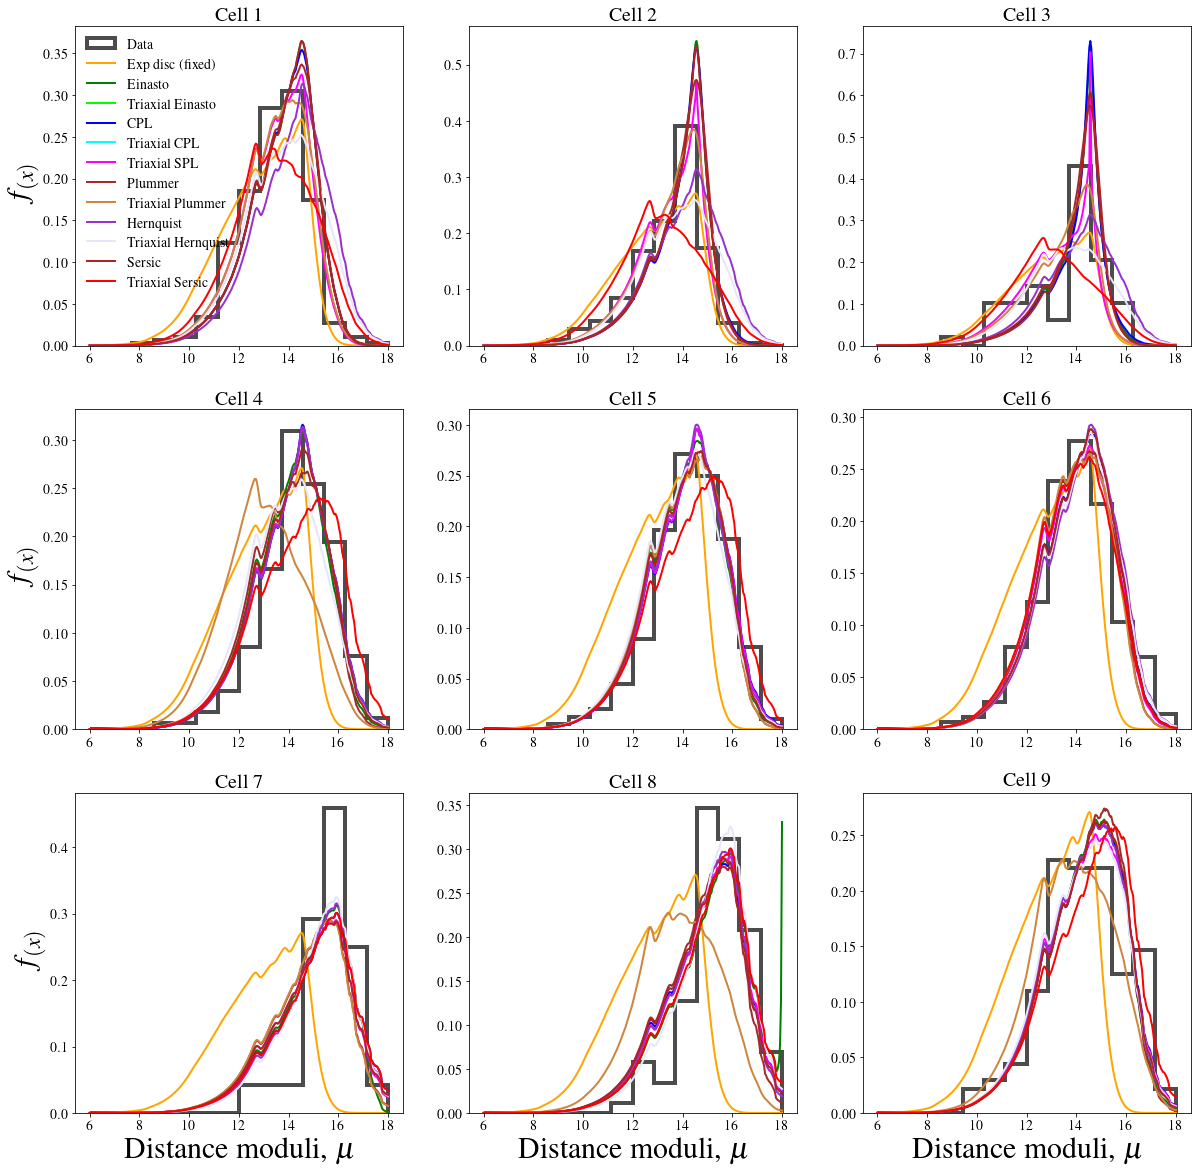

In [72]:
# plt.figure(figsize=(20,20), facecolor='white')

# plt.subplot(3,3,1)
# i = 0
# plt.title('Cell 1', fontsize=20)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# # plt.plot(distmods, pd_sph_cells[1],lw=2., color='k', label='Spherical')
# # plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=2., color='orange', label='Exp disc (fixed)')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_axi_cells[i],lw=2., color='lime', label='Triaxial Einasto')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_axi_cells[i],lw=2., color='cyan', label='Triaxial CPL')
# plt.plot(distmods, pd_halo_cells[i],lw=2., color='magenta', label='Triaxial SPL')
# plt.plot(distmods, pd_plummer_cells[i],lw=2., color='brown', label='Plummer')
# plt.plot(distmods, pd_plummer_axi_cells[i],lw=2., color='peru', label='Triaxial Plummer')
# # plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_axi_cells[i],lw=2., color='lavender', label='Triaxial Hernquist')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_axi_cells[i],lw=2., color='r', label='Triaxial Sersic')
# plt.legend(frameon=False,loc='upper left')
# # plt.xlabel('Distance moduli',fontsize=24)
# plt.ylabel(r'$f_{(x)}$',fontsize=30)

# plt.subplot(3,3,2)
# i = 1
# plt.title('Cell 2', fontsize=20)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# # plt.plot(distmods, pd_sph_cells[1],lw=2., color='k', label='Spherical')
# # plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=2., color='orange', label='Exp disc (fixed)')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_axi_cells[i],lw=2., color='lime', label='Triaxial Einasto')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_axi_cells[i],lw=2., color='cyan', label='Triaxial CPL')
# plt.plot(distmods, pd_halo_cells[i],lw=2., color='magenta', label='Triaxial SPL')
# plt.plot(distmods, pd_plummer_cells[i],lw=2., color='brown', label='Plummer')
# plt.plot(distmods, pd_plummer_axi_cells[i],lw=2., color='peru', label='Triaxial Plummer')
# # plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_axi_cells[i],lw=2., color='lavender', label='Triaxial Hernquist')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_axi_cells[i],lw=2., color='r', label='Triaxial Sersic')

# plt.subplot(3,3,3)
# i = 2
# plt.title('Cell 3', fontsize=20)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# # plt.plot(distmods, pd_sph_cells[1],lw=2., color='k', label='Spherical')
# # plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=2., color='orange', label='Exp disc (fixed)')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_axi_cells[i],lw=2., color='lime', label='Triaxial Einasto')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_axi_cells[i],lw=2., color='cyan', label='Triaxial CPL')
# plt.plot(distmods, pd_halo_cells[i],lw=2., color='magenta', label='Triaxial SPL')
# plt.plot(distmods, pd_plummer_cells[i],lw=2., color='brown', label='Plummer')
# plt.plot(distmods, pd_plummer_axi_cells[i],lw=2., color='peru', label='Triaxial Plummer')
# # plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_axi_cells[i],lw=2., color='lavender', label='Triaxial Hernquist')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_axi_cells[i],lw=2., color='r', label='Triaxial Sersic')

# plt.subplot(3,3,4)
# i = 3
# plt.title('Cell 4', fontsize=20)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# # plt.plot(distmods, pd_sph_cells[1],lw=2., color='k', label='Spherical')
# # plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=2., color='orange', label='Exp disc (fixed)')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_axi_cells[i],lw=2., color='lime', label='Triaxial Einasto')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_axi_cells[i],lw=2., color='cyan', label='Triaxial CPL')
# plt.plot(distmods, pd_halo_cells[i],lw=2., color='magenta', label='Triaxial SPL')
# plt.plot(distmods, pd_plummer_cells[i],lw=2., color='brown', label='Plummer')
# plt.plot(distmods, pd_plummer_axi_cells[i],lw=2., color='peru', label='Triaxial Plummer')
# # plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_axi_cells[i],lw=2., color='lavender', label='Triaxial Hernquist')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_axi_cells[i],lw=2., color='r', label='Triaxial Sersic')
# plt.ylabel(r'$f_{(x)}$',fontsize=30)

# plt.subplot(3,3,5)
# i = 4
# plt.title('Cell 5', fontsize=20)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# # plt.plot(distmods, pd_sph_cells[1],lw=2., color='k', label='Spherical')
# # plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=2., color='orange', label='Exp disc (fixed)')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_axi_cells[i],lw=2., color='lime', label='Triaxial Einasto')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_axi_cells[i],lw=2., color='cyan', label='Triaxial CPL')
# plt.plot(distmods, pd_halo_cells[i],lw=2., color='magenta', label='Triaxial SPL')
# plt.plot(distmods, pd_plummer_cells[i],lw=2., color='brown', label='Plummer')
# plt.plot(distmods, pd_plummer_axi_cells[i],lw=2., color='peru', label='Triaxial Plummer')
# # plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_axi_cells[i],lw=2., color='lavender', label='Triaxial Hernquist')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_axi_cells[i],lw=2., color='r', label='Triaxial Sersic')

# plt.subplot(3,3,6)
# i = 5
# plt.title('Cell 6', fontsize=20)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# # plt.plot(distmods, pd_sph_cells[1],lw=2., color='k', label='Spherical')
# # plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=2., color='orange', label='Exp disc (fixed)')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_axi_cells[i],lw=2., color='lime', label='Triaxial Einasto')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_axi_cells[i],lw=2., color='cyan', label='Triaxial CPL')
# plt.plot(distmods, pd_halo_cells[i],lw=2., color='magenta', label='Triaxial SPL')
# plt.plot(distmods, pd_plummer_cells[i],lw=2., color='brown', label='Plummer')
# plt.plot(distmods, pd_plummer_axi_cells[i],lw=2., color='peru', label='Triaxial Plummer')
# # plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_axi_cells[i],lw=2., color='lavender', label='Triaxial Hernquist')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_axi_cells[i],lw=2., color='r', label='Triaxial Sersic')
# plt.subplot(3,3,7)
# i = 6
# plt.title('Cell 7', fontsize=20)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# # plt.plot(distmods, pd_sph_cells[1],lw=2., color='k', label='Spherical')
# # plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=2., color='orange', label='Exp disc (fixed)')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_axi_cells[i],lw=2., color='lime', label='Triaxial Einasto')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_axi_cells[i],lw=2., color='cyan', label='Triaxial CPL')
# plt.plot(distmods, pd_halo_cells[i],lw=2., color='magenta', label='Triaxial SPL')
# plt.plot(distmods, pd_plummer_cells[i],lw=2., color='brown', label='Plummer')
# plt.plot(distmods, pd_plummer_axi_cells[i],lw=2., color='peru', label='Triaxial Plummer')
# # plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_axi_cells[i],lw=2., color='lavender', label='Triaxial Hernquist')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_axi_cells[i],lw=2., color='r', label='Triaxial Sersic')
# plt.xlabel('Distance moduli, $\mu$',fontsize=30)
# plt.ylabel(r'$f_{(x)}$',fontsize=30)

# plt.subplot(3,3,8)
# i = 7
# plt.title('Cell 8', fontsize=20)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# # plt.plot(distmods, pd_sph_cells[1],lw=2., color='k', label='Spherical')
# # plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=2., color='orange', label='Exp disc (fixed)')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_axi_cells[i],lw=2., color='lime', label='Triaxial Einasto')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_axi_cells[i],lw=2., color='cyan', label='Triaxial CPL')
# plt.plot(distmods, pd_halo_cells[i],lw=2., color='magenta', label='Triaxial SPL')
# plt.plot(distmods, pd_plummer_cells[i],lw=2., color='brown', label='Plummer')
# plt.plot(distmods, pd_plummer_axi_cells[i],lw=2., color='peru', label='Triaxial Plummer')
# # plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_axi_cells[i],lw=2., color='lavender', label='Triaxial Hernquist')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_axi_cells[i],lw=2., color='r', label='Triaxial Sersic')
# plt.xlabel('Distance moduli, $\mu$',fontsize=30)

# plt.subplot(3,3,9)
# i = 8
# plt.title('Cell 9', fontsize=20)
# data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
# plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],15), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# # plt.plot(distmods, pd_sph_cells[1],lw=2., color='k', label='Spherical')
# # plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=2., color='orange', label='Exp disc (fixed)')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_axi_cells[i],lw=2., color='lime', label='Triaxial Einasto')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_axi_cells[i],lw=2., color='cyan', label='Triaxial CPL')
# plt.plot(distmods, pd_halo_cells[i],lw=2., color='magenta', label='Triaxial SPL')
# plt.plot(distmods, pd_plummer_cells[i],lw=2., color='brown', label='Plummer')
# plt.plot(distmods, pd_plummer_axi_cells[i],lw=2., color='peru', label='Triaxial Plummer')
# # plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_axi_cells[i],lw=2., color='lavender', label='Triaxial Hernquist')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_axi_cells[i],lw=2., color='r', label='Triaxial Sersic')
# plt.xlabel('Distance moduli, $\mu$',fontsize=30)


# plt.savefig('../plots/all-fits-cells.pdf', format='pdf', dpi=200, bbox_inches='tight')


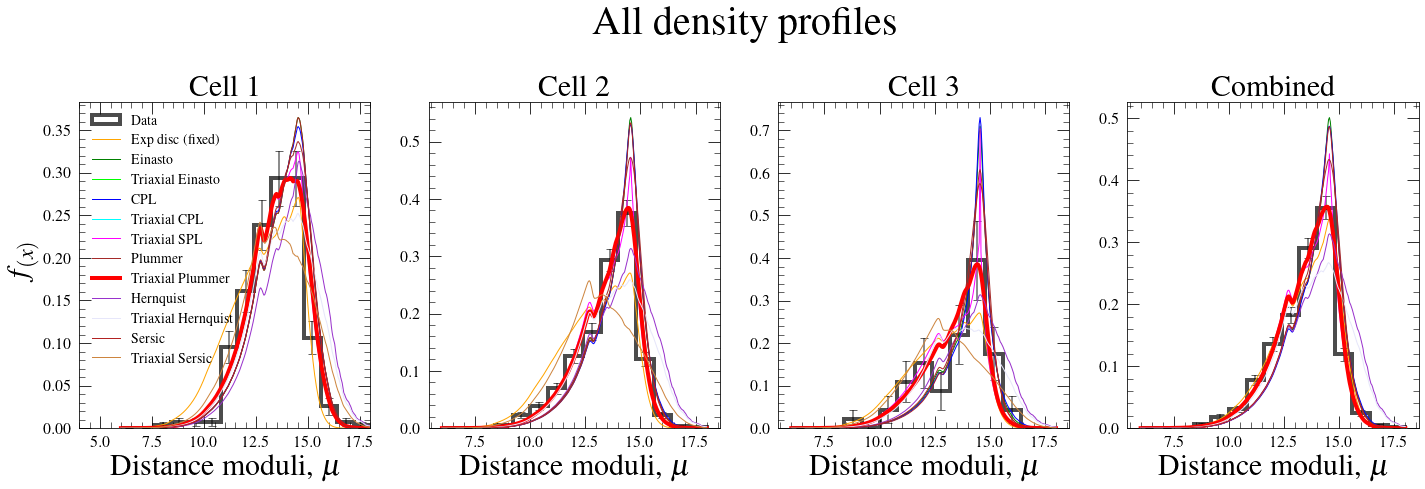

In [142]:
n = 16

fig = plt.figure(figsize=(24,6), facecolor='white')

fig.suptitle('All density profiles',fontsize=40,x=0.51,y=1.1)

plt.subplot(1,4,1)
i = 0
plt.title('Cell 1', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods, pd_sph_cells[1],lw=1., color='k', label='Spherical')
# plt.plot(distmods,pd_expdisc_cells[i],lw=1., color='darkorange', label='Exp disc')
plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=1., color='orange', label='Exp disc (fixed)')
plt.plot(distmods,pd_ein_cells[i],lw=1., color='g', label='Einasto')
plt.plot(distmods,pd_ein_axi_cells[i],lw=1., color='lime', label='Triaxial Einasto')
plt.plot(distmods, pd_coredpl_cells[i],lw=1., color='b', label='CPL')
plt.plot(distmods, pd_coredpl_axi_cells[i],lw=1., color='cyan', label='Triaxial CPL')
plt.plot(distmods, pd_halo_cells[i],lw=1., color='magenta', label='Triaxial SPL')
plt.plot(distmods, pd_plummer_cells[i],lw=1., color='brown', label='Plummer')
plt.plot(distmods, pd_plummer_axi_cells[i],lw=4., color='r', label='Triaxial Plummer')
# plt.plot(distmods, pd_plummer_disc_cells[i],lw=1., color='peru', label='Plummer + disc')
plt.plot(distmods, pd_hernquist_cells[i],lw=1., color='darkorchid', label='Hernquist')
plt.plot(distmods, pd_hernquist_axi_cells[i],lw=1., color='lavender', label='Triaxial Hernquist')
plt.plot(distmods, pd_sersic_cells[i],lw=1., color='firebrick', label='Sersic')
plt.plot(distmods, pd_sersic_axi_cells[i],lw=1., color='peru', label='Triaxial Sersic')
plt.legend(frameon=False,loc='upper left')
# plt.xlabel('Distance moduli',fontsize=24)
plt.ylabel(r'$f_{(x)}$',fontsize=30)
plt.xlabel('Distance moduli, $\mu$',fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()
plt.xlim(4,18)

plt.subplot(1,4,2)
i = 1
plt.title('Cell 2', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods, pd_sph_cells[1],lw=1., color='k', label='Spherical')
# plt.plot(distmods,pd_expdisc_cells[i],lw=1., color='darkorange', label='Exp disc')
plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=1., color='orange', label='Exp disc (fixed)')
plt.plot(distmods,pd_ein_cells[i],lw=1., color='g', label='Einasto')
plt.plot(distmods,pd_ein_axi_cells[i],lw=1., color='lime', label='Triaxial Einasto')
plt.plot(distmods, pd_coredpl_cells[i],lw=1., color='b', label='CPL')
plt.plot(distmods, pd_coredpl_axi_cells[i],lw=1., color='cyan', label='Triaxial CPL')
plt.plot(distmods, pd_halo_cells[i],lw=1., color='magenta', label='Triaxial SPL')
plt.plot(distmods, pd_plummer_cells[i],lw=1., color='brown', label='Plummer')
plt.plot(distmods, pd_plummer_axi_cells[i],lw=4., color='r', label='Triaxial Plummer')
# plt.plot(distmods, pd_plummer_disc_cells[i],lw=1., color='peru', label='Plummer + disc')
plt.plot(distmods, pd_hernquist_cells[i],lw=1., color='darkorchid', label='Hernquist')
plt.plot(distmods, pd_hernquist_axi_cells[i],lw=1., color='lavender', label='Triaxial Hernquist')
plt.plot(distmods, pd_sersic_cells[i],lw=1., color='firebrick', label='Sersic')
plt.plot(distmods, pd_sersic_axi_cells[i],lw=1., color='peru', label='Triaxial Sersic')
plt.xlabel('Distance moduli, $\mu$',fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(1,4,3)
i = 2
plt.title('Cell 3', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods, pd_sph_cells[1],lw=1., color='k', label='Spherical')
# plt.plot(distmods,pd_expdisc_cells[i],lw=1., color='darkorange', label='Exp disc')
plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=1., color='orange', label='Exp disc (fixed)')
plt.plot(distmods,pd_ein_cells[i],lw=1., color='g', label='Einasto')
plt.plot(distmods,pd_ein_axi_cells[i],lw=1., color='lime', label='Triaxial Einasto')
plt.plot(distmods, pd_coredpl_cells[i],lw=1., color='b', label='CPL')
plt.plot(distmods, pd_coredpl_axi_cells[i],lw=1., color='cyan', label='Triaxial CPL')
plt.plot(distmods, pd_halo_cells[i],lw=1., color='magenta', label='Triaxial SPL')
plt.plot(distmods, pd_plummer_cells[i],lw=1., color='brown', label='Plummer')
plt.plot(distmods, pd_plummer_axi_cells[i],lw=4., color='r', label='Triaxial Plummer')
# plt.plot(distmods, pd_plummer_disc_cells[i],lw=1., color='peru', label='Plummer + disc')
plt.plot(distmods, pd_hernquist_cells[i],lw=1., color='darkorchid', label='Hernquist')
plt.plot(distmods, pd_hernquist_axi_cells[i],lw=1., color='lavender', label='Triaxial Hernquist')
plt.plot(distmods, pd_sersic_cells[i],lw=1., color='firebrick', label='Sersic')
plt.plot(distmods, pd_sersic_axi_cells[i],lw=1., color='peru', label='Triaxial Sersic')
plt.xlabel('Distance moduli, $\mu$',fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(1,4,4)
plt.title('Combined', fontsize=30)
data_distmod= 5*np.log10(data['weighted_dist'][mask_tot]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods, pd_sph_cells[1],lw=1., color='k', label='Spherical')
# plt.plot(distmods,pd_expdisc_cells[i],lw=1., color='darkorange', label='Exp disc')
plt.plot(distmods,expdisc_comb_pd,lw=1., color='orange', label='Exp disc (fixed)')
plt.plot(distmods,ein_comb_pd,lw=1., color='g', label='Einasto')
plt.plot(distmods,ein_axi_comb_pd,lw=1., color='lime', label='Triaxial Einasto')
plt.plot(distmods, cpl_comb_pd,lw=1., color='b', label='CPL')
plt.plot(distmods, cpl_axi_comb_pd,lw=1., color='cyan', label='Triaxial CPL')
plt.plot(distmods, halo_comb_pd,lw=1., color='magenta', label='Triaxial SPL')
plt.plot(distmods, plummer_comb_pd,lw=1., color='brown', label='Plummer')
plt.plot(distmods, plummer_axi_comb_pd,lw=4., color='r', label='Triaxial Plummer')
# plt.plot(distmods, pd_plummer_disc_cells[i],lw=1., color='peru', label='Plummer + disc')
plt.plot(distmods, hern_comb_pd,lw=1., color='darkorchid', label='Hernquist')
plt.plot(distmods, hern_axi_comb_pd,lw=1., color='lavender', label='Triaxial Hernquist')
plt.plot(distmods, sersic_comb_pd,lw=1., color='firebrick', label='Sersic')
plt.plot(distmods, sersic_axi_comb_pd,lw=1., color='peru', label='Triaxial Sersic')
plt.xlabel('Distance moduli, $\mu$',fontsize=30)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.savefig('../plots/all-fits-cells1-3-comb.pdf', format='pdf', dpi=200, bbox_inches='tight')


# Calculate the BIC and AIC for the best fitting profiles in cells 1, 2, and 3

In [51]:
# CELL 1
cell = 0
print('LIKELIHOOD')
# print("exp disc: " +str(round(lhood_expdisc_cells[cell],3)))
print("einasto: " +str(round(lhood_ein_cells[cell],3)))
print("einasto tri: " +str(round(lhood_ein_axi_cells[cell],3)))
print("Cored power law: " +str(round(lhood_coredpl_cells[cell],3)))
print("Cored power law tri: " +str(round(lhood_coredpl_axi_cells[cell],3)))
print("plummer: " +str(round(lhood_plummer_cells[cell],3)))
print("plummer tri: " +str(round(lhood_plummer_axi_cells[cell],3)))
print("hernquist: " +str(round(lhood_hernquist_cells[cell],3)))
print("hernquist tri: " +str(round(lhood_hernquist_axi_cells[cell],3)))
print("sersic: " +str(round(lhood_sersic_cells[cell],3)))
print("sersic tri: " +str(round(lhood_sersic_axi_cells[cell],3)))
print("halo: " +str(round(lhood_halo_cells[cell],3)))

print('BIC')
# print("exp disc: " +str(round(bic_expdisc_cells[cell],3)))
print("einasto: " +str(round(bic_ein_cells[cell],3)))
print("einasto tri: " +str(round(bic_ein_axi_cells[cell],3)))
print("Cored power law: " +str(round(bic_coredpl_cells[cell],3)))
print("Cored power law tri: " +str(round(bic_coredpl_axi_cells[cell],3)))
print("plummer: " +str(round(bic_plummer_cells[cell],3)))
print("plummer tri: " +str(round(bic_plummer_axi_cells[cell],3)))
print("hernquist: " +str(round(bic_hernquist_cells[cell],3)))
print("hernquist tri: " +str(round(bic_hernquist_axi_cells[cell],3)))
print("sersic: " +str(round(bic_sersic_cells[cell],3)))
print("sersic tri: " +str(round(bic_sersic_axi_cells[cell],3)))
print("halo: " +str(round(bic_halo_cells[cell],3)))

print('AIC')
print("einasto: " +str(round(aic_ein_cells[cell],3)))
print("einasto tri: " +str(round(aic_ein_axi_cells[cell],3)))
print("Cored power law: " +str(round(aic_coredpl_cells[cell],3)))
print("Cored power law tri: " +str(round(aic_coredpl_axi_cells[cell],3)))
print("plummer: " +str(round(aic_plummer_cells[cell],3)))
print("plummer tri: " +str(round(aic_plummer_axi_cells[cell],3)))
print("hernquist: " +str(round(aic_hernquist_cells[cell],3)))
print("hernquist tri: " +str(round(aic_hernquist_axi_cells[cell],3)))
print("sersic: " +str(round(aic_sersic_cells[cell],3)))
print("sersic tri: " +str(round(aic_sersic_axi_cells[cell],3)))
print("halo: " +str(round(aic_halo_cells[cell],3)))


LIKELIHOOD
einasto: 2921.592
einasto tri: inf
Cored power law: 2921.671
Cored power law tri: inf
plummer: 2923.731
plummer tri: 2914.645
hernquist: 2994.277
hernquist tri: 2991.909
sersic: 2921.592
sersic tri: 3161.615
halo: 2907.427
BIC
einasto: 27.624
einasto tri: inf
Cored power law: 27.624
Cored power law tri: inf
plummer: 21.793
plummer tri: 33.451
hernquist: 21.841
hernquist tri: 33.503
sersic: 33.455
sersic tri: 45.277
halo: 62.605
AIC
einasto: 19.96
einasto tri: inf
Cored power law: 19.96
Cored power law tri: inf
plummer: 17.961
plummer tri: 21.955
hernquist: 18.009
hernquist tri: 22.007
sersic: 21.96
sersic tri: 26.118
halo: 31.95


In [52]:
# CELL 2
cell = 1
print('LIKELIHOOD')
# print("exp disc: " +str(round(lhood_expdisc_cells[cell],3)))
print("einasto: " +str(round(lhood_ein_cells[cell],3)))
print("einasto tri: " +str(round(lhood_ein_axi_cells[cell],3)))
print("Cored power law: " +str(round(lhood_coredpl_cells[cell],3)))
print("Cored power law tri: " +str(round(lhood_coredpl_axi_cells[cell],3)))
print("plummer: " +str(round(lhood_plummer_cells[cell],3)))
print("plummer tri: " +str(round(lhood_plummer_axi_cells[cell],3)))
print("hernquist: " +str(round(lhood_hernquist_cells[cell],3)))
print("hernquist tri: " +str(round(lhood_hernquist_axi_cells[cell],3)))
print("sersic: " +str(round(lhood_sersic_cells[cell],3)))
print("sersic tri: " +str(round(lhood_sersic_axi_cells[cell],3)))
print("halo: " +str(round(lhood_halo_cells[cell],3)))

print('BIC')
# print("exp disc: " +str(round(bic_expdisc_cells[cell],3)))
print("einasto: " +str(round(bic_ein_cells[cell],3)))
print("einasto tri: " +str(round(bic_ein_axi_cells[cell],3)))
print("Cored power law: " +str(round(bic_coredpl_cells[cell],3)))
print("Cored power law tri: " +str(round(bic_coredpl_axi_cells[cell],3)))
print("plummer: " +str(round(bic_plummer_cells[cell],3)))
print("plummer tri: " +str(round(bic_plummer_axi_cells[cell],3)))
print("hernquist: " +str(round(bic_hernquist_cells[cell],3)))
print("hernquist tri: " +str(round(bic_hernquist_axi_cells[cell],3)))
print("sersic: " +str(round(bic_sersic_cells[cell],3)))
print("sersic tri: " +str(round(bic_sersic_axi_cells[cell],3)))
print("halo: " +str(round(bic_halo_cells[cell],3)))

print('AIC')
print("einasto: " +str(round(aic_ein_cells[cell],3)))
print("einasto tri: " +str(round(aic_ein_axi_cells[cell],3)))
print("Cored power law: " +str(round(aic_coredpl_cells[cell],3)))
print("Cored power law tri: " +str(round(aic_coredpl_axi_cells[cell],3)))
print("plummer: " +str(round(aic_plummer_cells[cell],3)))
print("plummer tri: " +str(round(aic_plummer_axi_cells[cell],3)))
print("hernquist: " +str(round(aic_hernquist_cells[cell],3)))
print("hernquist tri: " +str(round(aic_hernquist_axi_cells[cell],3)))
print("sersic: " +str(round(aic_sersic_cells[cell],3)))
print("sersic tri: " +str(round(aic_sersic_axi_cells[cell],3)))
print("halo: " +str(round(aic_halo_cells[cell],3)))


LIKELIHOOD
einasto: 7574.148
einasto tri: inf
Cored power law: 7580.594
Cored power law tri: inf
plummer: 7613.614
plummer tri: 7529.87
hernquist: 7993.104
hernquist tri: 7973.999
sersic: 7574.324
sersic tri: 8698.376
halo: 7485.884
BIC
einasto: 31.609
einasto tri: inf
Cored power law: 31.611
Cored power law tri: inf
plummer: 24.748
plummer tri: 38.47
hernquist: 24.845
hernquist tri: 38.584
sersic: 38.481
sersic tri: 52.502
halo: 72.819
AIC
einasto: 21.865
einasto tri: inf
Cored power law: 21.867
Cored power law tri: inf
plummer: 19.875
plummer tri: 23.853
hernquist: 19.973
hernquist tri: 23.968
sersic: 23.865
sersic tri: 28.142
halo: 33.842


In [53]:
# CELL 3
cell = 2
print('LIKELIHOOD')
# print("exp disc: " +str(round(lhood_expdisc_cells[cell],3)))
print("einasto: " +str(round(lhood_ein_cells[cell],3)))
print("einasto tri: " +str(round(lhood_ein_axi_cells[cell],3)))
print("Cored power law: " +str(round(lhood_coredpl_cells[cell],3)))
print("Cored power law tri: " +str(round(lhood_coredpl_axi_cells[cell],3)))
print("plummer: " +str(round(lhood_plummer_cells[cell],3)))
print("plummer tri: " +str(round(lhood_plummer_axi_cells[cell],3)))
print("hernquist: " +str(round(lhood_hernquist_cells[cell],3)))
print("hernquist tri: " +str(round(lhood_hernquist_axi_cells[cell],3)))
print("sersic: " +str(round(lhood_sersic_cells[cell],3)))
print("sersic tri: " +str(round(lhood_sersic_axi_cells[cell],3)))
print("halo: " +str(round(lhood_halo_cells[cell],3)))

print('BIC')
# print("exp disc: " +str(round(bic_expdisc_cells[cell],3)))
print("einasto: " +str(round(bic_ein_cells[cell],3)))
print("einasto tri: " +str(round(bic_ein_axi_cells[cell],3)))
print("Cored power law: " +str(round(bic_coredpl_cells[cell],3)))
print("Cored power law tri: " +str(round(bic_coredpl_axi_cells[cell],3)))
print("plummer: " +str(round(bic_plummer_cells[cell],3)))
print("plummer tri: " +str(round(bic_plummer_axi_cells[cell],3)))
print("hernquist: " +str(round(bic_hernquist_cells[cell],3)))
print("hernquist tri: " +str(round(bic_hernquist_axi_cells[cell],3)))
print("sersic: " +str(round(bic_sersic_cells[cell],3)))
print("sersic tri: " +str(round(bic_sersic_axi_cells[cell],3)))
print("halo: " +str(round(bic_halo_cells[cell],3)))

print('AIC')
print("einasto: " +str(round(aic_ein_cells[cell],3)))
print("einasto tri: " +str(round(aic_ein_axi_cells[cell],3)))
print("Cored power law: " +str(round(aic_coredpl_cells[cell],3)))
print("Cored power law tri: " +str(round(aic_coredpl_axi_cells[cell],3)))
print("plummer: " +str(round(aic_plummer_cells[cell],3)))
print("plummer tri: " +str(round(aic_plummer_axi_cells[cell],3)))
print("hernquist: " +str(round(aic_hernquist_cells[cell],3)))
print("hernquist tri: " +str(round(aic_hernquist_axi_cells[cell],3)))
print("sersic: " +str(round(aic_sersic_cells[cell],3)))
print("sersic tri: " +str(round(aic_sersic_axi_cells[cell],3)))
print("halo: " +str(round(aic_halo_cells[cell],3)))


LIKELIHOOD
einasto: 422.32
einasto tri: inf
Cored power law: 423.514
Cored power law tri: inf
plummer: 429.304
plummer tri: 409.568
hernquist: 455.783
hernquist tri: 451.595
sersic: 423.042
sersic tri: 494.664
halo: 411.11
BIC
einasto: 20.178
einasto tri: inf
Cored power law: 20.183
Cored power law tri: inf
plummer: 16.167
plummer tri: 24.159
hernquist: 16.287
hernquist tri: 24.355
sersic: 24.224
sersic tri: 32.623
halo: 44.382
AIC
einasto: 16.092
einasto tri: inf
Cored power law: 16.097
Cored power law tri: inf
plummer: 14.124
plummer tri: 18.03
hernquist: 14.244
hernquist tri: 18.226
sersic: 18.095
sersic tri: 22.408
halo: 28.038


In [68]:
# CELL 5
cell = 4
print('LIKELIHOOD')
# print("exp disc: " +str(round(lhood_expdisc_cells[cell],3)))
print("einasto: " +str(round(lhood_ein_cells[cell],3)))
print("einasto tri: " +str(round(lhood_ein_axi_cells[cell],3)))
print("Cored power law: " +str(round(lhood_coredpl_cells[cell],3)))
print("Cored power law tri: " +str(round(lhood_coredpl_axi_cells[cell],3)))
print("plummer: " +str(round(lhood_plummer_cells[cell],3)))
print("plummer tri: " +str(round(lhood_plummer_axi_cells[cell],3)))
print("hernquist: " +str(round(lhood_hernquist_cells[cell],3)))
print("hernquist tri: " +str(round(lhood_hernquist_axi_cells[cell],3)))
print("sersic: " +str(round(lhood_sersic_cells[cell],3)))
print("sersic tri: " +str(round(lhood_sersic_axi_cells[cell],3)))
print("halo: " +str(round(lhood_halo_cells[cell],3)))

print('BIC')
# print("exp disc: " +str(round(bic_expdisc_cells[cell],3)))
print("einasto: " +str(round(bic_ein_cells[cell],3)))
print("einasto tri: " +str(round(bic_ein_axi_cells[cell],3)))
print("Cored power law: " +str(round(bic_coredpl_cells[cell],3)))
print("Cored power law tri: " +str(round(bic_coredpl_axi_cells[cell],3)))
print("plummer: " +str(round(bic_plummer_cells[cell],3)))
print("plummer tri: " +str(round(bic_plummer_axi_cells[cell],3)))
print("hernquist: " +str(round(bic_hernquist_cells[cell],3)))
print("hernquist tri: " +str(round(bic_hernquist_axi_cells[cell],3)))
print("sersic: " +str(round(bic_sersic_cells[cell],3)))
print("sersic tri: " +str(round(bic_sersic_axi_cells[cell],3)))
print("halo: " +str(round(bic_halo_cells[cell],3)))

print('AIC')
print("einasto: " +str(round(aic_ein_cells[cell],3)))
print("einasto tri: " +str(round(aic_ein_axi_cells[cell],3)))
print("Cored power law: " +str(round(aic_coredpl_cells[cell],3)))
print("Cored power law tri: " +str(round(aic_coredpl_axi_cells[cell],3)))
print("plummer: " +str(round(aic_plummer_cells[cell],3)))
print("plummer tri: " +str(round(aic_plummer_axi_cells[cell],3)))
print("hernquist: " +str(round(aic_hernquist_cells[cell],3)))
print("hernquist tri: " +str(round(aic_hernquist_axi_cells[cell],3)))
print("sersic: " +str(round(aic_sersic_cells[cell],3)))
print("sersic tri: " +str(round(aic_sersic_axi_cells[cell],3)))
print("halo: " +str(round(aic_halo_cells[cell],3)))


LIKELIHOOD
einasto: 18667.022
einasto tri: inf
Cored power law: 18628.491
Cored power law tri: inf
plummer: 18837.73
plummer tri: 18837.811
hernquist: 18636.575
hernquist tri: 18686.251
sersic: 18684.144
sersic tri: 19201.498
halo: 18630.419
BIC
einasto: 34.825
einasto tri: inf
Cored power law: 34.821
Cored power law tri: inf
plummer: 27.265
plummer tri: 42.422
hernquist: 27.244
hernquist tri: 42.406
sersic: 42.405
sersic tri: 57.616
halo: 80.29
AIC
einasto: 23.669
einasto tri: inf
Cored power law: 23.665
Cored power law tri: inf
plummer: 21.687
plummer tri: 25.687
hernquist: 21.666
hernquist tri: 25.671
sersic: 25.671
sersic tri: 29.725
halo: 35.665


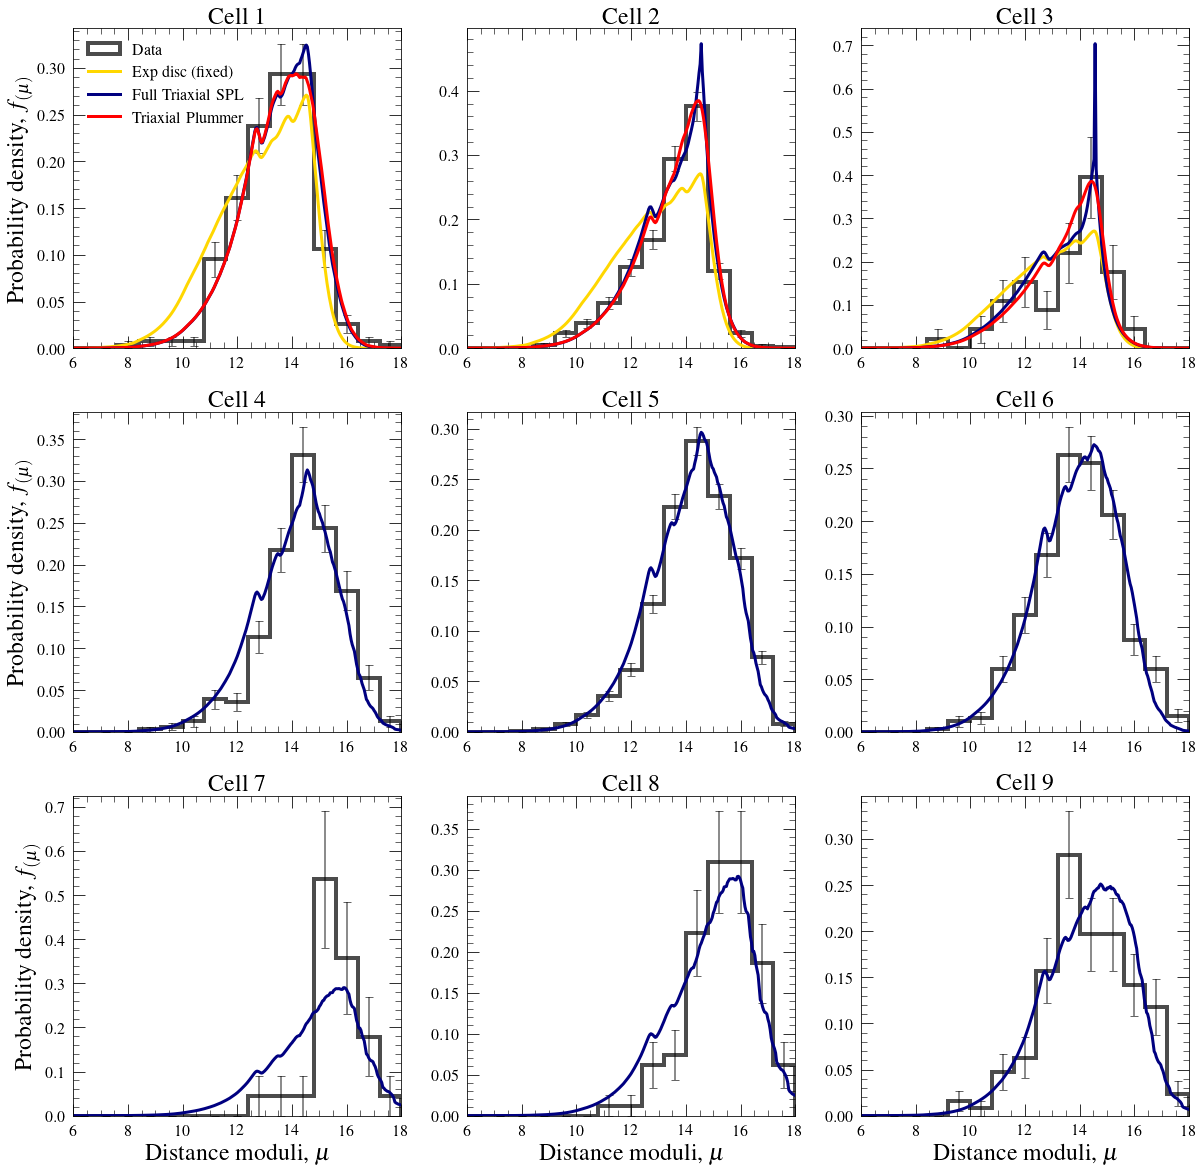

In [54]:
plt.figure(figsize=(20,20), facecolor='white')

n = 16

plt.subplot(3,3,1)
i = 0
plt.title('Cell 1', fontsize=24)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods, pd_sph_cells[1],lw=2., color='k', label='Spherical')
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=3., color='gold', label='Exp disc (fixed)')
# plt.plot(distmods,pd_ein_cells[i],lw=3., color='gold', label='Einasto')
# plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='lime', label='Einasto + disc')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_disc_cells[i],lw=2., color='cyan', label='CPL + disc')
plt.plot(distmods, pd_halo_cells[i], color='navy', label='Full Triaxial SPL', lw=3)
# plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=3., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_disc_cells[i],lw=2., color='lavender', label='Hernquist + disc')
# plt.plot(distmods, pd_sersic_cells[i],lw=3., color='dodgerblue', label='Sersic')
# plt.plot(distmods, pd_sersic_disc_cells[i],lw=2., color='r', label='Sersic + disc')
# plt.plot(distmods, pd_plummer_cells[i], color='r', label='Plummer', lw=3)
plt.plot(distmods, pd_plummer_axi_cells[i], color='r', label='Triaxial Plummer', lw=3)
plt.legend(frameon=False,loc='upper left', fontsize=16)
# plt.xlabel('Distance moduli',fontsize=24)
plt.ylabel(r'Probability density, $f_{(\mu)}$',fontsize=24)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,2)
i = 1
plt.title('Cell 2', fontsize=24)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods, pd_sph_cells[1],lw=2., color='k', label='Spherical')
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=3., color='gold', label='Exp disc (fixed)')
# plt.plot(distmods,pd_ein_cells[i],lw=3., color='gold', label='Einasto')
# plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='lime', label='Einasto + disc')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_disc_cells[i],lw=2., color='cyan', label='CPL + disc')
plt.plot(distmods, pd_halo_cells[i], color='navy', label='Full Triaxial SPL', lw=3)
# plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=3., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_disc_cells[i],lw=2., color='lavender', label='Hernquist + disc')
# plt.plot(distmods, pd_sersic_cells[i],lw=3., color='dodgerblue', label='Sersic')
# plt.plot(distmods, pd_sersic_disc_cells[i],lw=2., color='r', label='Sersic + disc')
# plt.plot(distmods, pd_plummer_cells[i], color='r', label='Plummer', lw=3)
plt.plot(distmods, pd_plummer_axi_cells[i], color='r', label='Triaxial Plummer', lw=3)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,3)
i = 2
plt.title('Cell 3', fontsize=24)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods, pd_sph_cells[1],lw=2., color='k', label='Spherical')
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
plt.plot(distmods,pd_expdisc_fixed_cells[i],lw=3., color='gold', label='Exp disc (fixed)')
# plt.plot(distmods,pd_ein_cells[i],lw=3., color='gold', label='Einasto')
# plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='lime', label='Einasto + disc')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_disc_cells[i],lw=2., color='cyan', label='CPL + disc')
plt.plot(distmods, pd_halo_cells[i], color='navy', label='Full Triaxial SPL', lw=3)
# plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=3., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_disc_cells[i],lw=2., color='lavender', label='Hernquist + disc')
# plt.plot(distmods, pd_sersic_cells[i],lw=3., color='dodgerblue', label='Sersic')
# plt.plot(distmods, pd_plummer_cells[i], color='r', label='Plummer', lw=3)
plt.plot(distmods, pd_plummer_axi_cells[i], color='r', label='Triaxial Plummer', lw=3)
# plt.plot(distmods, pd_sersic_disc_cells[i],lw=2., color='r', label='Sersic + disc')
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,4)
i = 3
plt.title('Cell 4', fontsize=24)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='lime', label='Einasto + disc')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_disc_cells[i],lw=2., color='cyan', label='CPL + disc')
plt.plot(distmods, pd_halo_cells[i], color='navy', label='Full Triaxial SPL', lw=3)
# plt.plot(distmods, pd_plummer_cells[i], color='firebrick', label='Plummer', lw=3, ls='--')
# plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_disc_cells[i],lw=2., color='lavender', label='Hernquist + disc')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_disc_cells[i],lw=2., color='r', label='Sersic + disc')
plt.ylabel(r'Probability density, $f_{(\mu)}$',fontsize=24)
# plt.legend(frameon=False,loc='upper left', fontsize=18)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,5)
i = 4
plt.title('Cell 5', fontsize=24)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='lime', label='Einasto + disc')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_disc_cells[i],lw=2., color='cyan', label='CPL + disc')
plt.plot(distmods, pd_halo_cells[i], color='navy', label='Full Triaxial SPL', lw=3)
# plt.plot(distmods, pd_plummer_cells[i], color='firebrick', label='Plummer', lw=3, ls='--')
# plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_disc_cells[i],lw=2., color='lavender', label='Hernquist + disc')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_disc_cells[i],lw=2., color='r', label='Sersic + disc')
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,6)
i = 5
plt.title('Cell 6', fontsize=24)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='lime', label='Einasto + disc')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_disc_cells[i],lw=2., color='cyan', label='CPL + disc')
plt.plot(distmods, pd_halo_cells[i], color='navy', label='Full Triaxial SPL', lw=3)
# plt.plot(distmods, pd_plummer_cells[i], color='firebrick', label='Plummer', lw=3, ls='--')
# plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_disc_cells[i],lw=2., color='lavender', label='Hernquist + disc')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_disc_cells[i],lw=2., color='r', label='Sersic + disc')
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,7)
i = 6
plt.title('Cell 7', fontsize=24)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='lime', label='Einasto + disc')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_disc_cells[i],lw=2., color='cyan', label='CPL + disc')
plt.plot(distmods, pd_halo_cells[i], color='navy', label='Full Triaxial SPL', lw=3)
# plt.plot(distmods, pd_plummer_cells[i], color='firebrick', label='Plummer', lw=3, ls='--')
# plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_disc_cells[i],lw=2., color='lavender', label='Hernquist + disc')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_disc_cells[i],lw=2., color='r', label='Sersic + disc')
plt.xlabel('Distance moduli, $\mu$',fontsize=24)
plt.ylabel(r'Probability density, $f_{(\mu)}$',fontsize=24)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,8)
i = 7
plt.title('Cell 8', fontsize=24)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='lime', label='Einasto + disc')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_disc_cells[i],lw=2., color='cyan', label='CPL + disc')
plt.plot(distmods, pd_halo_cells[i], color='navy', label='Full Triaxial SPL', lw=3)
# plt.plot(distmods, pd_plummer_cells[i], color='firebrick', label='Plummer', lw=3, ls='--')
# plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_disc_cells[i],lw=2., color='lavender', label='Hernquist + disc')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_disc_cells[i],lw=2., color='r', label='Sersic + disc')
plt.xlabel('Distance moduli, $\mu$',fontsize=24)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(3,3,9)
i = 8
plt.title('Cell 9', fontsize=24)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],n), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
y, bin_edges = np.histogram(data_distmod, bins=np.linspace(distmods[0],distmods[-1],n))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dens = y/(np.sum(y)* np.diff(bin_edges))
plt.errorbar(bin_centers,dens, yerr = np.sqrt(y)/(np.sum(y)* np.diff(bin_edges)), marker = '',linestyle='', ecolor='k', capsize=4, alpha=0.6)
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='g', label='Einasto')
# plt.plot(distmods,pd_ein_disc_cells[i],lw=2., color='lime', label='Einasto + disc')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='b', label='CPL')
# plt.plot(distmods, pd_coredpl_disc_cells[i],lw=2., color='cyan', label='CPL + disc')
plt.plot(distmods, pd_halo_cells[i], color='navy', label='Full Triaxial SPL', lw=3)
# plt.plot(distmods, pd_plummer_cells[i], color='firebrick', label='Plummer', lw=3, ls='--')
# plt.plot(distmods, pd_plummer_disc_cells[i],lw=2., color='peru', label='Plummer + disc')
# plt.plot(distmods, pd_hernquist_cells[i],lw=2., color='darkorchid', label='Hernquist')
# plt.plot(distmods, pd_hernquist_disc_cells[i],lw=2., color='lavender', label='Hernquist + disc')
# plt.plot(distmods, pd_sersic_cells[i],lw=2., color='firebrick', label='Sersic')
# plt.plot(distmods, pd_sersic_disc_cells[i],lw=2., color='r', label='Sersic + disc')
plt.xlabel('Distance moduli, $\mu$',fontsize=24)
plt.xlim(6,18)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()


# calc the mass for the chemical cells 1, 2, and 3

In [53]:
mask_tot = np.any([c1, c2, c3], axis=0)


In [55]:
Indices = mask_tot

opt_cell1, samples_cell1, sampler_cell1, masses_cell1, facs_cell1 = fit_bin_mask(Indices, fehrange=[-2.,-0.5], effsel=outarea, model=densprofiles.plummer_axi, just_MLE=False, just_MCMC=False, mass=True, init= [3., 0., 0.], ncut=100, analytic=False)


1363
<function fit_bin_mask.<locals>.<lambda> at 0x68fd2a1f0>
Optimization terminated successfully.
         Current function value: 10902.263243
         Iterations: 172
         Function evaluations: 313
[3.48079539 0.79782025 0.6602776 ]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1441 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [56]:
# save the values
np.save('../sav/opt_plummer_tri_combined1through3', opt_cell1[0])
np.save('../sav/lhood_plummer_tri_combined1through3', opt_cell1[1])
np.save('../sav/samples_plummer_tri_combined1through3', samples_cell1)
np.save('../sav/sampler_plummer_tri_combined1through3', sampler_cell1)
np.save('../sav/masses_plummer_tri_combined1through3', masses_cell1)
np.save('../sav/facs_plummer_tri_combined1through3', facs_cell1)

array([2.16064393e+09, 2.21034684e+09, 2.22940021e+09, 2.13921459e+09,
       2.17078244e+09, 2.25785728e+09, 2.20806478e+09, 2.31317191e+09,
       2.19424195e+09, 2.15658930e+09, 2.39022494e+09, 2.13776751e+09,
       2.25099338e+09, 2.13348577e+09, 2.28384374e+09, 2.12559450e+09,
       2.17638617e+09, 2.16551322e+09, 2.11637263e+09, 2.11796333e+09,
       2.14281720e+09, 2.27487251e+09, 2.17859721e+09, 2.18550644e+09,
       2.30725903e+09, 2.30009325e+09, 2.21364486e+09, 2.21937343e+09,
       2.25342629e+09, 2.18248406e+09, 2.14465566e+09, 2.20324085e+09,
       2.17573239e+09, 2.24874709e+09, 2.22690228e+09, 2.35311205e+09,
       2.20660664e+09, 2.14214867e+09, 2.17758603e+09, 2.29972933e+09,
       2.21989371e+09, 2.21735170e+09, 2.27573135e+09, 2.21272301e+09,
       2.16148426e+09, 2.22460744e+09, 2.05527177e+09, 2.32126431e+09,
       2.16273509e+09, 2.33705772e+09, 2.17127584e+09, 2.13411081e+09,
       2.19897813e+09, 2.29993968e+09, 2.02667081e+09, 2.19138620e+09,
      

In [ ]:
per = np.percentile(masses_plummer_cell1, [16,50,84])
per

In [ ]:
Indices = masks_c[1]

opt_cell2, samples_cell2, sampler_cell2, masses_cell2, facs_cell2 = fit_bin_mask(Indices, fehrange=[-1.5,-1.], effsel=outarea, model=densprofiles.plummer_axi, just_MLE=False, just_MCMC=False, mass=True, init= opt_plummer_axi_cells[1], ncut=100, analytic=False)


In [ ]:
per2 = np.percentile(masses_plummer_cell2, [16,50,84])
per2

In [ ]:
Indices = masks_c[2]

opt_cell3, samples_cell3, sampler_cell3, masses_cell3, facs_cell3 = fit_bin_mask(Indices, fehrange=[-1.,-0.5], effsel=outarea, model=densprofiles.plummer_axi, just_MLE=False, just_MCMC=False, mass=True, init= opt_plummer_axi_cells[2], ncut=100, analytic=False)


In [ ]:
per3 = np.percentile(masses_plummer_cell3, [16,50,84])
per3

In [ ]:
tot = per+per2+per3
tot

In [ ]:
# save the values
np.save('../sav/opt_plummer_tri_cell1', opt_cell1[0])
np.save('../sav/lhood_plummer_tri_cell1', opt_cell1[1])
np.save('../sav/samples_plummer_tri_cell1', samples_cell1)
np.save('../sav/sampler_plummer_tri_cell1', sampler_cell1)
np.save('../sav/masses_plummer_tri_cell1', masses_cell1)
np.save('../sav/facs_plummer_tri_cell1', facs_cell1)

np.save('../sav/opt_plummer_tri_cell2', opt_cell2[0])
np.save('../sav/lhood_plummer_tri_cell2', opt_cell2[1])
np.save('../sav/samples_plummer_tri_cell2', samples_cell2)
np.save('../sav/sampler_plummer_tri_cell2', sampler_cell2)
np.save('../sav/masses_plummer_tri_cell2', masses_cell2)
np.save('../sav/facs_plummer_tri_cell2', facs_cell2)

np.save('../sav/opt_plummer_tri_cell3', opt_cell3[0])
np.save('../sav/lhood_plummer_tri_cell3', opt_cell3[1])
np.save('../sav/samples_plummer_tri_cell3', samples_cell3)
np.save('../sav/sampler_plummer_tri_cell3', sampler_cell3)
np.save('../sav/masses_plummer_tri_cell3', masses_cell3)
np.save('../sav/facs_plummer_tri_cell3', facs_cell3)


In [ ]:
Indices = masks_c[3]

opt_cell4, samples_cell4, sampler_cell4, masses_cell4, facs_cell4 = fit_bin_mask(Indices, fehrange=[-2.,-1.5], effsel=outarea, model=densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, just_MLE=False, just_MCMC=False, mass=True, init= opt_halo_cells[3], ncut=100, analytic=False)


In [ ]:
Indices = masks_c[4]

opt_cell5, samples_cell5, sampler_cell5, masses_cell5, facs_cell5 = fit_bin_mask(Indices, fehrange=[-1.5,-1.], effsel=outarea, model=densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, just_MLE=False, just_MCMC=False, mass=True, init= opt_halo_cells[4], ncut=100, analytic=False)


In [ ]:
Indices = masks_c[5]

opt_cell6, samples_cell6, sampler_cell6, masses_cell6, facs_cell6 = fit_bin_mask(Indices, fehrange=[-1.,-0.5], effsel=outarea, model=densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, just_MLE=False, just_MCMC=False, mass=True, init= opt_halo_cells[5], ncut=100, analytic=False)


In [ ]:
Indices = masks_c[6]

opt_cell7, samples_cell7, sampler_cell7, masses_cell7, facs_cell7 = fit_bin_mask(Indices, fehrange=[-2.,-1.5], effsel=outarea, model=densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, just_MLE=False, just_MCMC=False, mass=True, init= opt_halo_cells[6], ncut=100, analytic=False)


In [ ]:
Indices = masks_c[7]

opt_cell8, samples_cell8, sampler_cell8, masses_cell8, facs_cell8 = fit_bin_mask(Indices, fehrange=[-1.5,-1.], effsel=outarea, model=densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, just_MLE=False, just_MCMC=False, mass=True, init= opt_halo_cells[7], ncut=100, analytic=False)


In [ ]:
Indices = masks_c[8]

opt_cell9, samples_cell9, sampler_cell9, masses_cell9, facs_cell9 = fit_bin_mask(Indices, fehrange=[-1.,-0.5], effsel=outarea, model=densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, just_MLE=False, just_MCMC=False, mass=True, init= opt_halo_cells[8], ncut=100, analytic=False)


In [ ]:
# save the values
np.save('../sav/opt_halo_cell4', opt_cell4[0])
np.save('../sav/lhood_halo_cell4', opt_cell4[1])
np.save('../sav/samples_halo_cell4', samples_cell4)
np.save('../sav/sampler_halo_cell4', sampler_cell4)
np.save('../sav/masses_halo_cell4', masses_cell4)
np.save('../sav/facs_halo_cell4', facs_cell4)

np.save('../sav/opt_halo_cell5', opt_cell5[0])
np.save('../sav/lhood_halo_cell5', opt_cell5[1])
np.save('../sav/samples_halo_cell5', samples_cell5)
np.save('../sav/sampler_halo_cell5', sampler_cell5)
np.save('../sav/masses_halo_cell5', masses_cell5)
np.save('../sav/facs_halo_cell5', facs_cell5)

np.save('../sav/opt_halo_cell6', opt_cell6[0])
np.save('../sav/lhood_halo_cell6', opt_cell6[1])
np.save('../sav/samples_halo_cell6', samples_cell6)
np.save('../sav/sampler_halo_cell6', sampler_cell6)
np.save('../sav/masses_halo_cell6', masses_cell6)
np.save('../sav/facs_halo_cell6', facs_cell6)

np.save('../sav/opt_halo_cell7', opt_cell7[0])
np.save('../sav/lhood_halo_cell7', opt_cell7[1])
np.save('../sav/samples_halo_cell7', samples_cell7)
np.save('../sav/sampler_halo_cell7', sampler_cell7)
np.save('../sav/masses_halo_cell7', masses_cell7)
np.save('../sav/facs_halo_cell7', facs_cell7)

np.save('../sav/opt_halo_cell8', opt_cell8[0])
np.save('../sav/lhood_halo_cell8', opt_cell8[1])
np.save('../sav/samples_halo_cell8', samples_cell8)
np.save('../sav/sampler_halo_cell8', sampler_cell8)
np.save('../sav/masses_halo_cell8', masses_cell8)
np.save('../sav/facs_halo_cell8', facs_cell8)

np.save('../sav/opt_halo_cell9', opt_cell9[0])
np.save('../sav/lhood_halo_cell9', opt_cell9[1])
np.save('../sav/samples_halo_cell9', samples_cell9)
np.save('../sav/sampler_halo_cell9', sampler_cell9)
np.save('../sav/masses_halo_cell9', masses_cell9)
np.save('../sav/facs_halo_cell9', facs_cell9)


In [ ]:
# load the values
opt_plummer_cell1 = np.load('../sav/opt_plummer_tri_cell1.npy', allow_pickle=True)
lhood_plummer_cell1 = np.load('../sav/lhood_plummer_tri_cell1.npy', allow_pickle=True)
samples_plummer_cell1 = np.load('../sav/samples_plummer_tri_cell1.npy', allow_pickle=True)
sampler_plummer_cell1 = np.load('../sav/sampler_plummer_tri_cell1.npy', allow_pickle=True)
masses_plummer_cell1 = np.load('../sav/masses_plummer_tri_cell1.npy', allow_pickle=True)
facs_plummer_cell1 = np.load('../sav/facs_plummer_tri_cell1.npy', allow_pickle=True)

opt_plummer_cell2 = np.load('../sav/opt_plummer_tri_cell2.npy', allow_pickle=True)
lhood_plummer_cell2 = np.load('../sav/lhood_plummer_tri_cell2.npy', allow_pickle=True)
samples_plummer_cell2 = np.load('../sav/samples_plummer_tri_cell2.npy', allow_pickle=True)
sampler_plummer_cell2 = np.load('../sav/sampler_plummer_tri_cell2.npy', allow_pickle=True)
masses_plummer_cell2 = np.load('../sav/masses_plummer_tri_cell2.npy', allow_pickle=True)
facs_plummer_cell2 = np.load('../sav/facs_plummer_tri_cell2.npy', allow_pickle=True)

opt_plummer_cell3 = np.load('../sav/opt_plummer_tri_cell3.npy', allow_pickle=True)
lhood_plummer_cell3 = np.load('../sav/lhood_plummer_tri_cell3.npy', allow_pickle=True)
samples_plummer_cell3 = np.load('../sav/samples_plummer_tri_cell3.npy', allow_pickle=True)
sampler_plummer_cell3 = np.load('../sav/sampler_plummer_tri_cell3.npy', allow_pickle=True)
masses_plummer_cell3 = np.load('../sav/masses_plummer_tri_cell3.npy', allow_pickle=True)
facs_plummer_cell3 = np.load('../sav/facs_plummer_tri_cell3.npy', allow_pickle=True)


In [ ]:
percen_masses_cell1 = np.percentile(masses_plummer_cell1, [16,50,84])
percen_masses_cell2 = np.percentile(masses_plummer_cell2, [16,50,84])
percen_masses_cell3 = np.percentile(masses_plummer_cell3, [16,50,84])

In [ ]:
percen_masses_cell1, percen_masses_cell2, percen_masses_cell3

In [ ]:
plt.figure(figsize=(14,4), facecolor='white')

# fig.suptitle('Posterior samples for Plummer profile',fontsize=40,x=0.52,y=1.3)


plt.subplot(1,3,1)
plt.title('Cell 1', fontsize=24)
percen = np.percentile(samples_plummer_cell1, [16,50,84])
plt.hist(samples_plummer_cell1, 64, histtype='step', color='navy', lw=4)
plt.hist(samples_plummer_cell1, 64, color='navy', alpha=0.3)
plt.vlines(percen[1], 0, 5800, color='r', lw=2, ls='--')
plt.vlines(percen[0], 0, 5800, color='r', lw=2, ls='dotted')
plt.vlines(percen[2], 0, 5800, color='r', lw=2, ls='dotted')
plt.text(5.2,5000, '$a$ = '+ str(round(percen[1],2))+' $^{+'+str(round(percen[2]-percen[1],2))+'}_{-'+str(round(percen[1]-percen[0], 2))+'}$', fontsize=16)
plt.xlabel('Plummer radius, $a$ [kpc]', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(1,3,2)
percen = np.percentile(samples_plummer_cell2, [16,50,84])
plt.title('Cell 2', fontsize=24)
plt.hist(samples_plummer_cell2, 64, histtype='step', color='navy', lw=4)
plt.hist(samples_plummer_cell2, 64, color='navy', alpha=0.3)
plt.vlines(percen[1], 0, 5200, color='r', lw=2, ls='--')
plt.vlines(percen[0], 0, 5200, color='r', lw=2, ls='dotted')
plt.vlines(percen[2], 0, 5200, color='r', lw=2, ls='dotted')
plt.text(3.4,4500, '$a$ = '+ str(round(percen[1],2))+' $^{+'+str(round(percen[2]-percen[1],2))+'}_{-'+str(round(percen[1]-percen[0], 2))+'}$', fontsize=16)
plt.xlabel('Plummer radius, $a$ [kpc]', fontsize=20)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()
plt.xlim(2.8,3.9)

plt.subplot(1,3,3)
percen = np.percentile(samples_plummer_cell3, [16,50,84])
plt.title('Cell 3', fontsize=24)
plt.hist(samples_plummer_cell3, 64, histtype='step', color='navy', lw=4)
plt.hist(samples_plummer_cell3, 64, color='navy', alpha=0.3)
plt.vlines(percen[1], 0, 6000, color='r', lw=2, ls='--')
plt.vlines(percen[0], 0, 6000, color='r', lw=2, ls='dotted')
plt.vlines(percen[2], 0, 6000, color='r', lw=2, ls='dotted')
plt.text(3.3,5000, '$a$ = '+ str(round(percen[1],2))+' $^{+'+str(round(percen[2]-percen[1],2))+'}_{-'+str(round(percen[1]-percen[0], 2))+'}$', fontsize=16)
plt.xlabel('Plummer radius, $a$ [kpc]', fontsize=20)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

# plt.savefig('../plots/plummer-disc-params-samples.pdf',dpi=200, bbox_inches = 'tight')


plt.show()


In [ ]:
plt.figure(figsize=(14,4), facecolor='white')

# fig.suptitle('Posterior samples for Plummer profile',fontsize=40,x=0.52,y=1.3)


plt.subplot(1,3,1)
plt.title('Cell 1', fontsize=24)
percen = np.percentile(samples_plummer_cell1, [16,50,84], axis=0)
plt.hist2d(samples_plummer_cell1[:,0], samples_plummer_cell1[:,1], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,0], 0, 5800, color='r', lw=2, ls='--')
plt.vlines(percen[0,0], 0, 5800, color='r', lw=2, ls='dotted')
plt.vlines(percen[2,0], 0, 5800, color='r', lw=2, ls='dotted')
plt.hlines(percen[1,1], 0, 5800, color='r', lw=2, ls='--')
plt.hlines(percen[0,1], 0, 5800, color='r', lw=2, ls='dotted')
plt.hlines(percen[2,1], 0, 5800, color='r', lw=2, ls='dotted')
# plt.text(5.2,5000, '$a$ = '+ str(round(percen[1],2))+' $^{+'+str(round(percen[2]-percen[1],2))+'}_{-'+str(round(percen[1]-percen[0], 2))+'}$', fontsize=16)
plt.xlabel('Plummer radius, $a$ [kpc]', fontsize=20)
plt.ylabel('$p$', fontsize=20)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

plt.subplot(1,3,2)
plt.title('Cell 2', fontsize=24)
percen = np.percentile(samples_plummer_cell2, [16,50,84], axis=0)
plt.hist2d(samples_plummer_cell2[:,0], samples_plummer_cell2[:,1], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,0], 0, 5800, color='r', lw=2, ls='--')
plt.vlines(percen[0,0], 0, 5800, color='r', lw=2, ls='dotted')
plt.vlines(percen[2,0], 0, 5800, color='r', lw=2, ls='dotted')
plt.hlines(percen[1,1], 0, 5800, color='r', lw=2, ls='--')
plt.hlines(percen[0,1], 0, 5800, color='r', lw=2, ls='dotted')
plt.hlines(percen[2,1], 0, 5800, color='r', lw=2, ls='dotted')
# plt.text(3.4,4500, '$a$ = '+ str(round(percen[1],2))+' $^{+'+str(round(percen[2]-percen[1],2))+'}_{-'+str(round(percen[1]-percen[0], 2))+'}$', fontsize=16)
plt.xlabel('Plummer radius, $a$ [kpc]', fontsize=20)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()
# plt.xlim(2.8,3.9)

plt.subplot(1,3,3)
plt.title('Cell 3', fontsize=24)
percen = np.percentile(samples_plummer_cell3, [16,50,84], axis=0)
plt.hist2d(samples_plummer_cell3[:,0], samples_plummer_cell3[:,1], bins=150, cmap=cm.voltage_r, norm=LogNorm())
plt.vlines(percen[1,0], 0, 5800, color='r', lw=2, ls='--')
plt.vlines(percen[0,0], 0, 5800, color='r', lw=2, ls='dotted')
plt.vlines(percen[2,0], 0, 5800, color='r', lw=2, ls='dotted')
plt.hlines(percen[1,1], 0, 5800, color='r', lw=2, ls='--')
plt.hlines(percen[0,1], 0, 5800, color='r', lw=2, ls='dotted')
plt.hlines(percen[2,1], 0, 5800, color='r', lw=2, ls='dotted')
# plt.text(3.3,5000, '$a$ = '+ str(round(percen[1],2))+' $^{+'+str(round(percen[2]-percen[1],2))+'}_{-'+str(round(percen[1]-percen[0], 2))+'}$', fontsize=16)
plt.xlabel('Plummer radius, $a$ [kpc]', fontsize=20)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

# plt.savefig('../plots/plummer-disc-params-samples.pdf',dpi=200, bbox_inches = 'tight')


plt.show()


In [ ]:
import matplotlib.gridspec as grid

In [ ]:
# fig = plt.figure(constrained_layout=True,figsize=(10,8))
# plt.rc('font',family='serif',size=14)
# gs = grid.GridSpec(3,3)

# fig.suptitle('Cell 1',fontsize=40,x=0.52,y=1.05)

# ax_main = plt.subplot(gs[1:3, :2])
# ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
# ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)

# percen = np.percentile(samples_plummer_cell1, [16,50,84], axis=0)
# ax_main.hist2d(samples_plummer_cell1[:,0], samples_plummer_cell1[:,1], bins=150, cmap=cm.voltage, norm=LogNorm())
# ax_main.set_xlabel('Plummer radius, $a$ [kpc]', fontsize=20)
# ax_main.set_ylabel('Disc fraction, $f_{\mathrm{disc}}$', fontsize=20)
# ax_main.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
# ax_main.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
# ax_main.minorticks_on()

# ax_xDist.hist(samples_plummer_cell1[:,0], 64, histtype='step', color='navy', lw=4)
# ax_xDist.hist(samples_plummer_cell1[:,0], 64, color='navy', alpha=0.3)
# ax_xDist.vlines(percen[1,0], 0, 5800, color='r', lw=2, ls='--')
# ax_xDist.vlines(percen[0,0], 0, 5800, color='r', lw=2, ls='dotted')
# ax_xDist.vlines(percen[2,0], 0, 5800, color='r', lw=2, ls='dotted')
# # ax_xDist.text(5.2,5000, '$a$ = '+ str(round(percen[1,0],2))+' $^{+'+str(round(percen[2,0]-percen[1,0],2))+'}_{-'+str(round(percen[1,0]-percen[0,0], 2))+'}$', fontsize=16)
# ax_xDist.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
# ax_xDist.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
# ax_xDist.minorticks_on()

# ax_yDist.hist(samples_plummer_cell1[:,1], 64, histtype='step', color='navy', lw=4,orientation='horizontal')
# ax_yDist.hist(samples_plummer_cell1[:,1], 64, color='navy', alpha=0.3,orientation='horizontal')
# ax_yDist.hlines(percen[1,1], 0, 4200, color='r', lw=2, ls='--')
# ax_yDist.hlines(percen[0,1], 0, 4200, color='r', lw=2, ls='dotted')
# ax_yDist.hlines(percen[2,1], 0, 4200, color='r', lw=2, ls='dotted')
# # ax_yDist.text(0.6,5000, '$f_{\mathrm{disc}}$ = '+ str(round(percen[1,1],2))+' $^{+'+str(round(percen[2,1]-percen[1,1],2))+'}_{-'+str(round(percen[1,1]-percen[0,1], 2))+'}$', fontsize=16)
# ax_yDist.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
# ax_yDist.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
# ax_yDist.minorticks_on()


In [ ]:
percen[1,1]

In [ ]:
from scipy import integrate
def calc_masses(model, facs, samples):
    rthetaphigrid = np.mgrid[0.1:40:150j,0:np.pi:150j,0:2*np.pi:150j]
    dr = (40-0.1)/149
    dtheta = (np.pi-0.)/149
    dphi = (2*np.pi-0.)/149
    deltafactor = rthetaphigrid[0]**2*np.sin(rthetaphigrid[1])*dtheta*dphi #here the rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1]) is the Jacobian
    x = rthetaphigrid[0]*np.sin(rthetaphigrid[1])*np.cos(rthetaphigrid[2])
    y = rthetaphigrid[0]*np.sin(rthetaphigrid[1])*np.sin(rthetaphigrid[2])
    z = rthetaphigrid[0]*np.cos(rthetaphigrid[1])
    rphizgrid = coords.rect_to_cyl(x, y, z)
    halomasses = np.empty((300,150))
    for ii,param in tqdm.tqdm_notebook(enumerate(samples[np.random.choice(len(samples), 300, replace=False)])):
        if model is densprofiles.spherical:
            r = np.linspace(0.1,40,150)
            for jj,rs in enumerate(r):
                rsun = np.sqrt(8.275**2+0.02**2)
                alpha = param[0]
                max_r = 12.
                min_r = 0.1
                r = np.linspace(0.1,40,150)
                integral = 4*np.pi*rsun**alpha*((max_r**(3-alpha))/(3-alpha)-((min_r+rs)**(3-alpha))/(3-alpha))
                masses[ii,jj] = integral*facs[ii]
        else:
            dens = model(rphizgrid[0], rphizgrid[1], rphizgrid[2], params=param)
            halogriddens = dens[0]*deltafactor
            haloraddens = np.sum(np.sum(halogriddens,axis=2),axis=1)
            halomasses[ii] = haloraddens*facs[ii]
    return halomasses


In [ ]:
mass_cell1 = calc_masses(densprofiles.plummer_axi, facs_plummer_cell1, samples_plummer_cell1)
# mass_cell2 = calc_masses(densprofiles.plummer_disc, facs_plummer_cell2, samples_plummer_cell2)
# mass_cell3 = calc_masses(densprofiles.plummer_disc, facs_plummer_cell3, samples_plummer_cell3)



In [ ]:
# calculate the mass in 25kpc from halo 
print('Within 40 kpc')
mass1 = np.nansum(mass_cell1,axis=1)*(40-0.1)/149
print(np.nanpercentile(mass1,[16,50,84]))
# calculate the mass in 6kpc from halo
print('Within 5 kpc')
mass1 = np.nansum(mass_cell1[:,:49],axis=1)*(40-0.1)/149
print(np.nanpercentile(mass1,[16,50,84]))


In [ ]:
# calculate the mass in 25kpc from halo 
print('Within 15 kpc')
mass2 = np.nansum(mass_cell2,axis=1)*(15-0.1)/149
print(np.nanpercentile(mass2,[16,50,84]))
# calculate the mass in 6kpc from halo
print('Within 5 kpc')
mass2 = np.nansum(mass_cell2[:,:49],axis=1)*(15-0.1)/149
print(np.nanpercentile(mass2,[16,50,84]))

In [ ]:
# calculate the mass in 25kpc from halo 
print('Within 15 kpc')
mass3 = np.nansum(mass_cell3,axis=1)*(15-0.1)/149
print(np.nanpercentile(mass3,[16,50,84]))
# calculate the mass in 6kpc from halo
print('Within 5 kpc')
mass3 = np.nansum(mass_cell3[:,:49],axis=1)*(15-0.1)/149
print(np.nanpercentile(mass3,[16,50,84]))

In [ ]:
1.17438267e+09*(1-0.7477)

In [ ]:
init_params

In [ ]:
init_params = np.array((np.median(samples_ein_disc_heracles[:,0]), np.median(samples_ein_disc_heracles[:,1]), np.median(samples_ein_disc_heracles[:,2])))
# opt = op.fmin(lambda x: utils.mloglike(x,densprofiles.einasto_expdisc, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][masks_c[1]],Rphiz[:,1][masks_c[1]], Rphiz[:,2][masks_c[1]]), init_params, full_output=True)
pd, pdt, rate = pdistmod_model(densprofiles.einasto_expdisc,init_params, outarea, returnrate=True)


In [ ]:
plt.figure(figsize=(7,5), facecolor='white')

i = 1
plt.title('Cell 2', fontsize=20)
data_distmod= 5*np.log10(data['weighted_dist'][masks_c[i]]/10.)
plt.hist(data_distmod, density=True, bins=np.linspace(distmods[0],distmods[-1],46), color='k', histtype='step',lw=4., alpha=0.7 , label='Data')
# plt.plot(distmods, pd_sph_cells[1],lw=2., color='k', label='Spherical')
# plt.plot(distmods,pd_expdisc_cells[i],lw=2., color='darkorange', label='Exp disc')
# plt.plot(distmods,pd_ein_cells[i],lw=2., color='lime', label='Einasto')
# plt.plot(distmods,pd_ein_halo_cells[i],lw=2., color='darkorchid', label='Einasto + GES halo')
# plt.plot(distmods,pd_ein_cutoff_cells[i],lw=2., color='orchid', label='Einasto + cutoff')
# plt.plot(distmods,pd_ein_cutoff_disc_cells[i],lw=2., color='dodgerblue', label='Einasto + cutoff + disc')
# plt.plot(distmods,pd_ein_cutoff_disc_cells[i],lw=2., color='g', label='Einasto + cutoff + disc')
plt.plot(distmods,pd,lw=2., color='r', label='Einasto + disc')
# plt.plot(distmods, pd_halo_cells[i],lw=2., color='b', label='Full Triaxial SPL')
# plt.plot(distmods, pd_coredpl_cells[i],lw=2., color='cyan', label='CPL')
plt.legend(frameon=False,loc='upper left')
plt.xlim(8,17)

In [ ]:
def fit_cells(densprofile, masks, init_params = [2.,5.]):
    
    opt_cells = []
    pd_cells = []
    pdt_cells = []
    rate_cells = [] 

    for indx, i in tqdm.tqdm_notebook(enumerate(masks)):
        opt = op.fmin(lambda x: utils.mloglike(x,densprofile, outarea[goodindx_eff]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx_eff], phigrid[goodindx_eff], zgrid[goodindx_eff], Rphiz[:,0][i],Rphiz[:,1][i], Rphiz[:,2][i]), init_params, full_output=True)
        pd, pdt, rate = pdistmod_model(densprofile,opt[0], outarea, returnrate=True)
        
        opt_cells.append(opt[0])
        pd_cells.append(pd) 
        pdt_cells.append(pdt) 
        rate_cells.append(rate)                      
                                       
    return np.array(opt_cells), np.array(pd_cells), np.array(pdt_cells), np.array(rate_cells)


In [ ]:
from scipy import integrate
def calc_masses(model, facs, samples):
    rthetaphigrid = np.mgrid[0.1:40:150j,0:np.pi:150j,0:2*np.pi:150j]
    dr = (40-0.1)/149
    dtheta = (np.pi-0.)/149
    dphi = (2*np.pi-0.)/149
    deltafactor = rthetaphigrid[0]**2*np.sin(rthetaphigrid[1])*dtheta*dphi #here the rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1]) is the Jacobian
    x = rthetaphigrid[0]*np.sin(rthetaphigrid[1])*np.cos(rthetaphigrid[2])
    y = rthetaphigrid[0]*np.sin(rthetaphigrid[1])*np.sin(rthetaphigrid[2])
    z = rthetaphigrid[0]*np.cos(rthetaphigrid[1])
    rphizgrid = coords.rect_to_cyl(x, y, z)
    halomasses = np.empty((300,150))
    for ii,param in tqdm.tqdm_notebook(enumerate(samples[np.random.choice(len(samples), 300, replace=False)])):
        if model is densprofiles.spherical:
            r = np.linspace(0.1,40,150)
            for jj,rs in enumerate(r):
                rsun = np.sqrt(8.275**2+0.02**2)
                alpha = param[0]
                max_r = 40.
                min_r = 0.1
                r = np.linspace(0.1,40,150)
                integral = 4*np.pi*rsun**alpha*((max_r**(3-alpha))/(3-alpha)-((min_r+rs)**(3-alpha))/(3-alpha))
                masses[ii,jj] = integral*facs[ii]
        else:
            dens = model(rphizgrid[0], rphizgrid[1], rphizgrid[2], params=param)
            halogriddens = dens[0]*deltafactor
            haloraddens = np.sum(np.sum(halogriddens,axis=2),axis=1)
            halomasses[ii] = haloraddens*facs[ii]
    return halomasses